# Research Question \#2

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd
from scipy.stats import chisquare, entropy
import numpy as np
import os
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from scipy.stats import ks_2samp
import numpy as np

# Data loading and Standardization

In [19]:
# --- Load Data (and clean Response) ---

path = "/content/drive/MyDrive/RQ2data.csv"  # REPLACE WITH FILE PATH WHEREVER YOU PUT THE DATA
if os.path.exists(path):
    try:
        df = pd.read_csv(path)
        df['Response'] = df['Response'].str.strip()
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error reading file: {e}")
        df = None
else:
    print(f"File not found: {path}")
    df = None

# --- Step 1: Standardizing Column Names ---
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()  # Convert column names to lowercase, remove spaces

# Step 2: Missing Values in Each Column ---
missing_values_per_column = df.isnull().sum()
print("\n🔹 Missing Values Per Column:")
print(missing_values_per_column)

# Step 3: Count Rows with Missing Values ---
missing_rows = df[df.isnull().any(axis=1)]  # Select rows where any value is missing
missing_rows_count = len(missing_rows)

print(f"\n🔹 Total Rows with Missing Values: {missing_rows_count}")

# Step 4: Display Rows with Missing Values ---
if missing_rows_count > 0:
    print("\n🔹 Sample Rows with Missing Values:")
    print(missing_rows.head(10))  # Show first 10 rows with missing values (adjust if needed)

# --- Step 5: Check Unique Values for Consistency ---
print("Unique LLMs:", df["llm"].unique())
print("Unique Techniques:", df["technique"].unique())
print("Unique Responses:", df["response"].unique())
print("Unique Questions:", df["questionid"].unique())

# --- Step 6: Count Occurrences of Each LLM ---
if 'llm' in df.columns:
    llm_counts = df['llm'].value_counts()  # Count each LLM occurrence
    print("\n🔹 LLM Occurrences in Dataset:")
    print(llm_counts)
else:
    print("\n'LLM' column not found in dataset!")

# --- Step 7: Count Responses for Each Technique, Grouped by LLM Name ---
if 'llm' in df.columns and 'technique' in df.columns:
    technique_counts = df.groupby(['llm', 'technique'])['response'].count().reset_index()
    print("\nResponse Count by Technique & LLM:")
    print(technique_counts)
else:
    print("\n'LLM' or 'Technique' column not found in dataset!")

# --- Step 8: Group by Question, LLM, and Technique ---
grouped_df = df.groupby(['llm', 'technique', 'questionid'])['response'].count().reset_index()


# --- Step 9: Display Grouped Data ---
print("\nResponse Count by Question, LLM, and Technique:")
print(grouped_df)

# --- Survey Data ---
survey_data = {
    1: {'A': 0.76, 'B': 0.24},
    2: {'A': 0.54, 'B': 0.30, 'C': 0.16},
    3: {'A': 0.17, 'B': 0.31, 'C': 0.41, 'D': 0.09, 'E': 0.01}
}

Data loaded successfully.

🔹 Missing Values Per Column:
llm           0
technique     0
questionid    0
response      0
dtype: int64

🔹 Total Rows with Missing Values: 0
Unique LLMs: ['GPT-4o-mini' 'Grok-3' 'Gemini-2.0-Pro' 'Copilot']
Unique Techniques: ['Basic_Prompting' 'Role_Prompting' 'One_Shot' 'Few_Shot']
Unique Responses: ['A' 'B' 'C' 'D' 'E']
Unique Questions: [1 2 3]

🔹 LLM Occurrences in Dataset:
llm
GPT-4o-mini       3216
Grok-3            3216
Gemini-2.0-Pro    3216
Copilot           3216
Name: count, dtype: int64

Response Count by Technique & LLM:
               llm        technique  response
0          Copilot  Basic_Prompting       804
1          Copilot         Few_Shot       804
2          Copilot         One_Shot       804
3          Copilot   Role_Prompting       804
4      GPT-4o-mini  Basic_Prompting       804
5      GPT-4o-mini         Few_Shot       804
6      GPT-4o-mini         One_Shot       804
7      GPT-4o-mini   Role_Prompting       804
8   Gemini-2.0-Pro

# Functions for Different Statistical Tests

In [20]:
# --- Functions for performing tests ---
def calculate_chi_square(df, llm_name, technique_name, question_id, survey_percentages):
    """Calculates Chi-Square, returns (chi2_stat, p_value, observed, expected, observed_labels) or (None, None, None, None, None)."""
    filtered_df = df[(df['llm'] == llm_name) & (df['technique'] == technique_name) & (df['questionid'] == question_id)]
    if filtered_df.empty:
        return None, None, None, None, None

    observed_counts = filtered_df['response'].value_counts().sort_index()
    observed_frequencies = observed_counts.values
    observed_labels = observed_counts.index.tolist()

    filtered_survey_percentages = {k: survey_percentages[k] for k in observed_counts.index if k in survey_percentages}
    expected_keys = list(filtered_survey_percentages.keys())
    observed_keys = list(observed_counts.index)

    if set(expected_keys) != set(observed_keys):
        print(f"Mismatched keys after filtering: Observed={observed_keys}, Expected={expected_keys}")
        return None, None, None, None, None

    expected_frequencies = [len(filtered_df) * filtered_survey_percentages[response] for response in observed_counts.index]

    diff = np.sum(observed_frequencies) - np.sum(expected_frequencies)
    if not np.isclose(diff, 0):
        adjustment = diff / len(expected_frequencies)
        expected_frequencies = [freq + adjustment for freq in expected_frequencies]

    if any(x == 0 for x in expected_frequencies):
        return None, None, None, None, None

    chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
    return chi2_stat, p_value, observed_frequencies, expected_frequencies, observed_labels

def calculate_euclidean(df, llm_name, technique_name, question_id, survey_percentages):
    """Calculates Euclidean Distance, returns (euclidean_dist, observed_percentages, expected_percentages) or (None, None, None)."""
    filtered_df = df[(df['llm'] == llm_name) & (df['technique'] == technique_name) & (df['questionid'] == question_id)]
    if filtered_df.empty:
        return None, None, None

    observed_counts = filtered_df['response'].value_counts().sort_index()
    observed_frequencies = observed_counts.values
    observed_percentages = observed_frequencies / len(filtered_df)

    filtered_survey_percentages = {k: survey_percentages[k] for k in observed_counts.index if k in survey_percentages}
    expected_keys = list(filtered_survey_percentages.keys())
    observed_keys = list(observed_counts.index)
    if set(expected_keys) != set(observed_keys):
        return None, None, None

    expected_frequencies = [len(filtered_df) * filtered_survey_percentages[response] for response in observed_counts.index]
    diff = np.sum(observed_frequencies) - np.sum(expected_frequencies)
    if not np.isclose(diff, 0):
        adjustment = diff / len(expected_frequencies)
        expected_frequencies = [freq + adjustment for freq in expected_frequencies]
    expected_percentages = np.array(expected_frequencies) / len(filtered_df)

    if any(x == 0 for x in expected_frequencies):
        return None, None, None

    observed_percentages = observed_percentages.reshape(1, -1)
    expected_percentages = expected_percentages.reshape(1, -1)
    euclidean_dist = euclidean_distances(observed_percentages, expected_percentages)[0][0]
    return euclidean_dist, observed_percentages, expected_percentages

def calculate_cosine(df, llm_name, technique_name, question_id, survey_percentages):
    """Calculates Cosine Similarity, returns (cosine_sim, observed_percentages, expected_percentages) or (None, None, None)."""
    filtered_df = df[(df['llm'] == llm_name) & (df['technique'] == technique_name) & (df['questionid'] == question_id)]
    if filtered_df.empty:
        return None, None, None

    observed_counts = filtered_df['response'].value_counts().sort_index()
    observed_frequencies = observed_counts.values
    observed_percentages = observed_frequencies / len(filtered_df)

    filtered_survey_percentages = {k: survey_percentages[k] for k in observed_counts.index if k in survey_percentages}
    expected_keys = list(filtered_survey_percentages.keys())
    observed_keys = list(observed_counts.index)
    if set(expected_keys) != set(observed_keys):
        return None, None, None

    expected_frequencies = [len(filtered_df) * filtered_survey_percentages[response] for response in observed_counts.index]
    diff = np.sum(observed_frequencies) - np.sum(expected_frequencies)
    if not np.isclose(diff, 0):
        adjustment = diff / len(expected_frequencies)
        expected_frequencies = [freq + adjustment for freq in expected_frequencies]
    expected_percentages = np.array(expected_frequencies) / len(filtered_df)


    if any(x == 0 for x in expected_frequencies):
        return None, None, None

    observed_percentages = observed_percentages.reshape(1, -1)
    expected_percentages = expected_percentages.reshape(1, -1)
    cosine_sim = cosine_similarity(observed_percentages, expected_percentages)[0][0]
    return cosine_sim, observed_percentages, expected_percentages



def calculate_ks_test(df, llm_name, technique_name, question_id, survey_percentages):
    """Performs Kolmogorov-Smirnov (KS) test for categorical response distributions (which is a bad idea)."""
    filtered_df = df[(df['llm'] == llm_name) & (df['technique'] == technique_name) & (df['questionid'] == question_id)]

    if filtered_df.empty:
        return None, None, None, None

    observed_counts = filtered_df['response'].value_counts().sort_index()
    observed_percentages = observed_counts / len(filtered_df)

    expected_percentages = np.array([survey_percentages.get(resp, 0) for resp in observed_counts.index])

    if len(observed_percentages) != len(expected_percentages):
        return None, None, None, None

    ks_stat, p_value = ks_2samp(observed_percentages, expected_percentages)

    return ks_stat, p_value, observed_percentages, expected_percentages


# Chi Square Results

Null Hypothesis: The distribution of responses for a given LLM and prompt engineering technique, on a specific question, is the same as the distribution of responses in the human survey for that question. In other words, there is no statistically significant difference between the LLM's responses and the expected frequencies based on the survey. The LLM's responses are consistent with the survey distribution.
Alternative Hypothesis: The distribution of responses for a given LLM and prompt engineering technique, on a specific question, is different from the distribution of responses in the human survey for that question. There is a statistically significant difference between the LLM's responses and the expected frequencies. The LLM's responses are not consistent with the survey distribution.
Using a p value threshold of 0.05, if our results are less than 0.05 it means we can reject the null hypothesis. If our p values are greater than 0.05 we don't reject the null as the observed data 

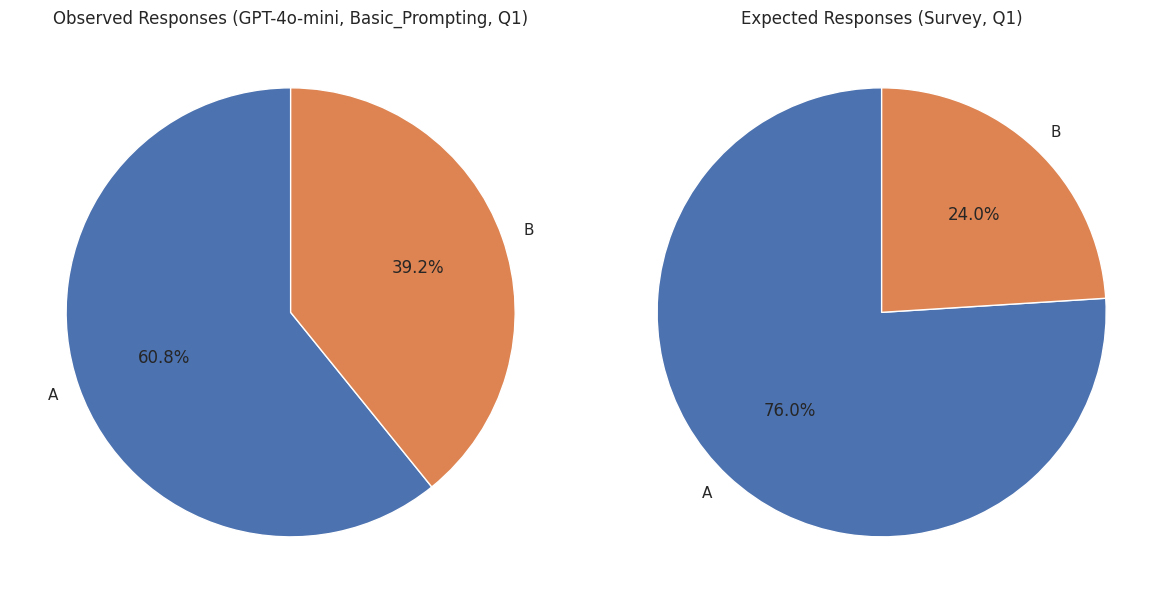


--- Results for GPT-4o-mini, Basic_Prompting, Question 2 ---
Chi-Square Statistic: 9.6131
P-value: 0.008175815882291356
Observed Frequencies: [128  79  61]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


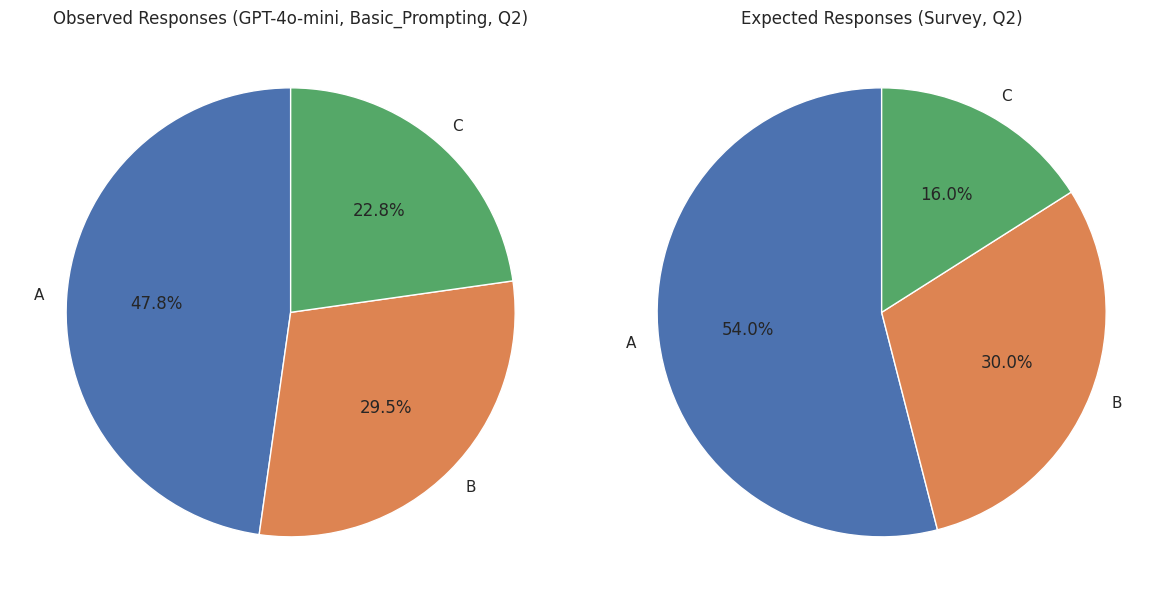


--- Results for GPT-4o-mini, Basic_Prompting, Question 3 ---
Chi-Square Statistic: 786.5761
P-value: 6.208405805916619e-169
Observed Frequencies: [56 51 56 54 51]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


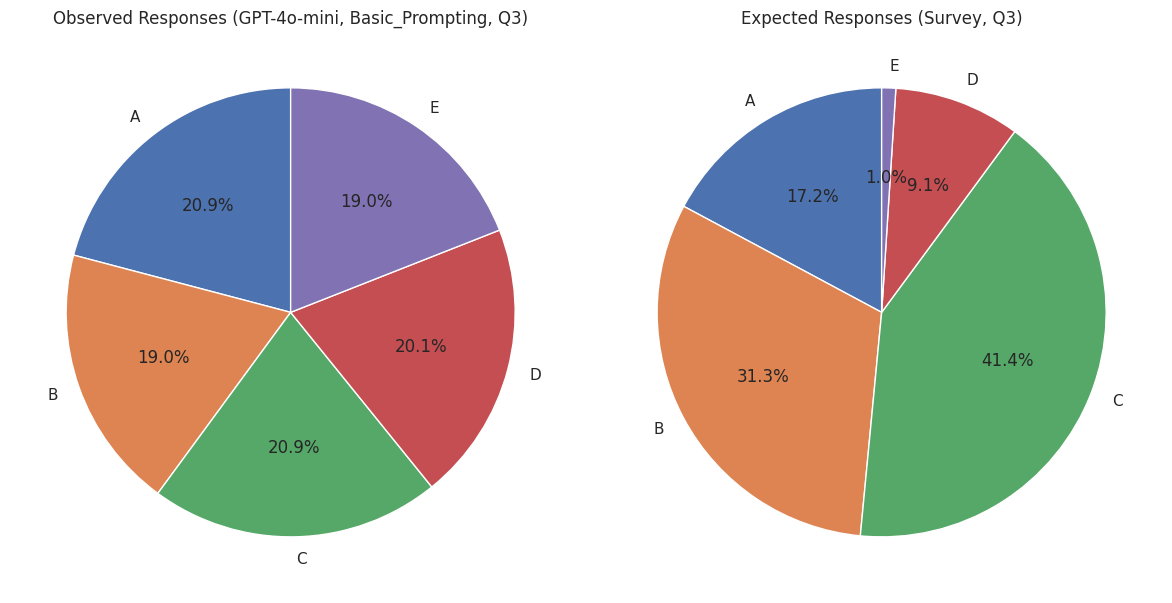


--- Results for GPT-4o-mini, Role_Prompting, Question 1 ---
Chi-Square Statistic: 20.5310
P-value: 5.86723918543216e-06
Observed Frequencies: [172  96]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


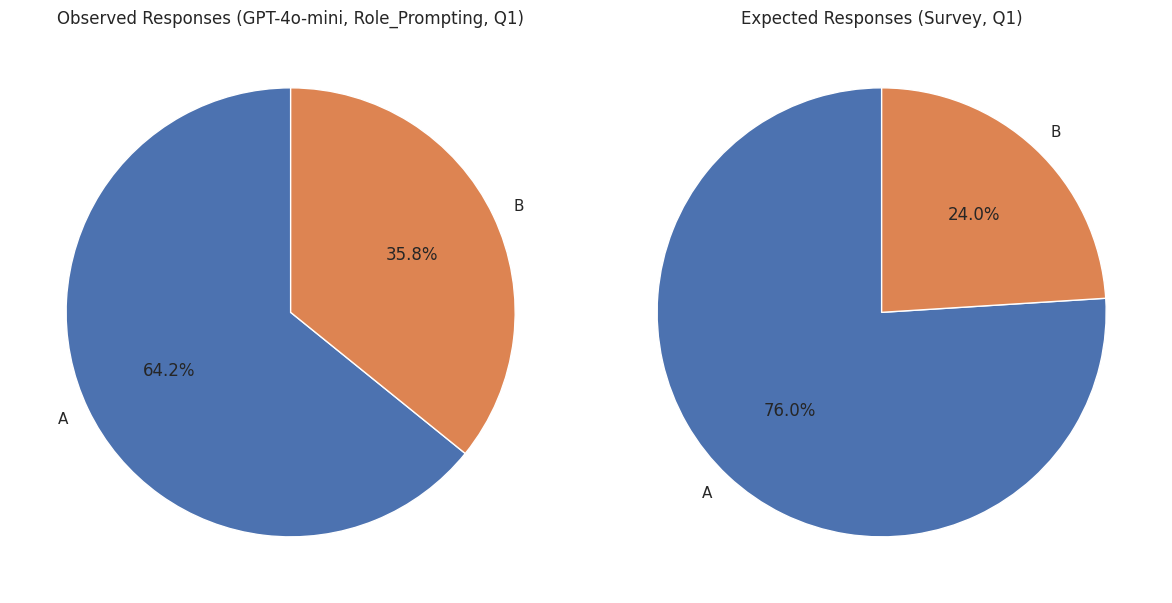


--- Results for GPT-4o-mini, Role_Prompting, Question 2 ---
Chi-Square Statistic: 6.8727
P-value: 0.03218217366588742
Observed Frequencies: [140  97  31]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


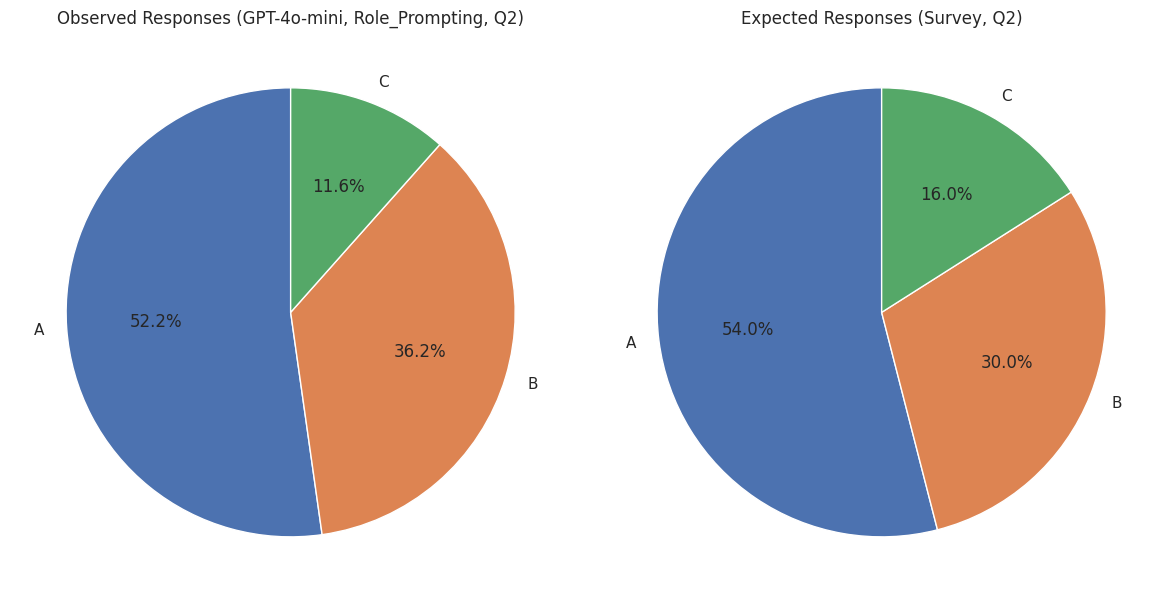


--- Results for GPT-4o-mini, Role_Prompting, Question 3 ---
Chi-Square Statistic: 725.6036
P-value: 9.95511768436697e-156
Observed Frequencies: [58 47 61 53 49]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


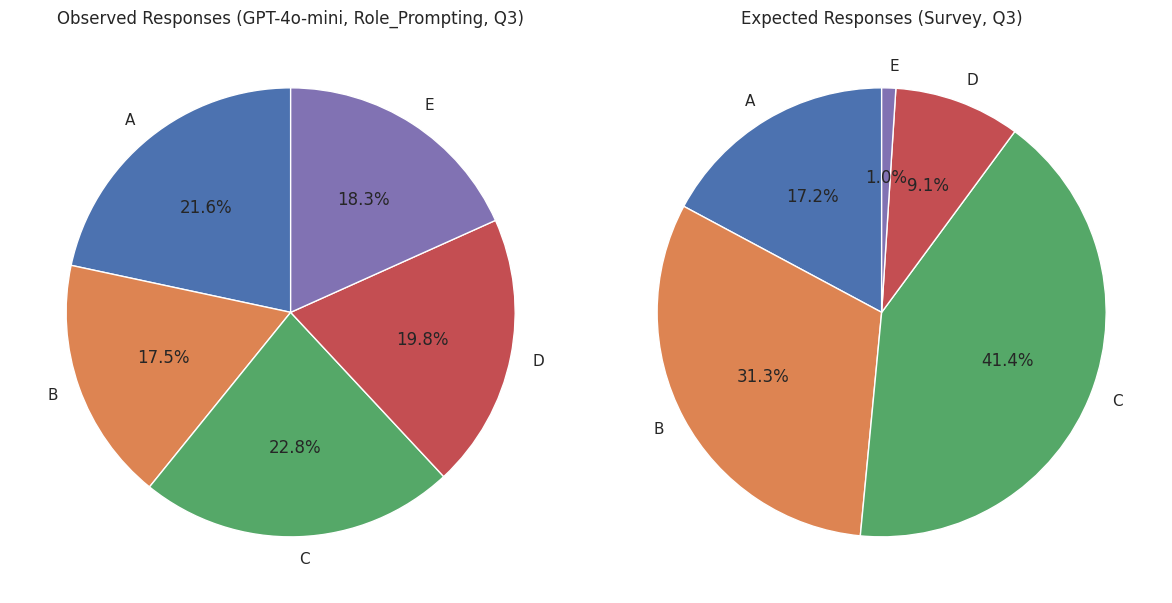


--- Results for GPT-4o-mini, One_Shot, Question 1 ---
Chi-Square Statistic: 44.5761
P-value: 2.4466013691812253e-11
Observed Frequencies: [157 111]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


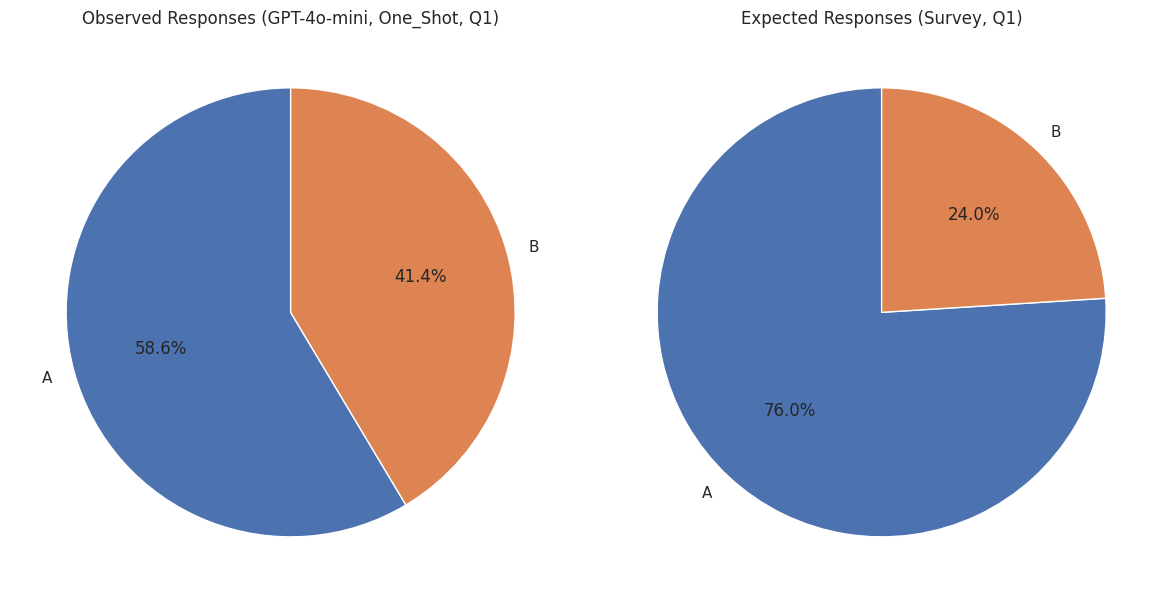


--- Results for GPT-4o-mini, One_Shot, Question 2 ---
Chi-Square Statistic: 41.3503
P-value: 1.0492937031935559e-09
Observed Frequencies: [113  74  81]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


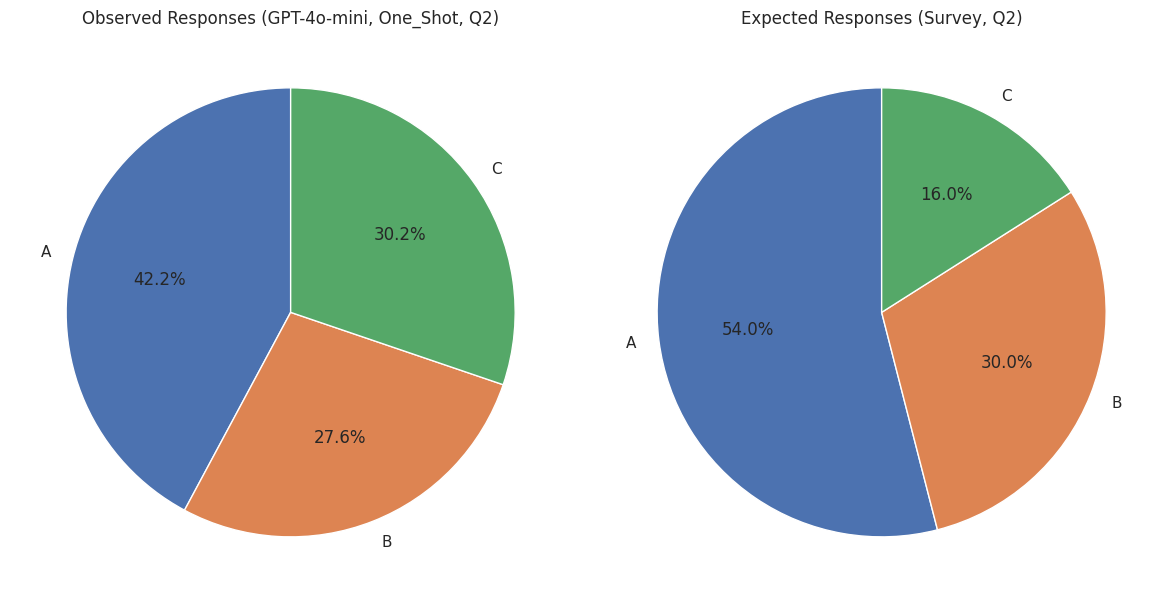


--- Results for GPT-4o-mini, One_Shot, Question 3 ---
Chi-Square Statistic: 464.2407
P-value: 3.6223689498843445e-99
Observed Frequencies: [56 52 67 54 39]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


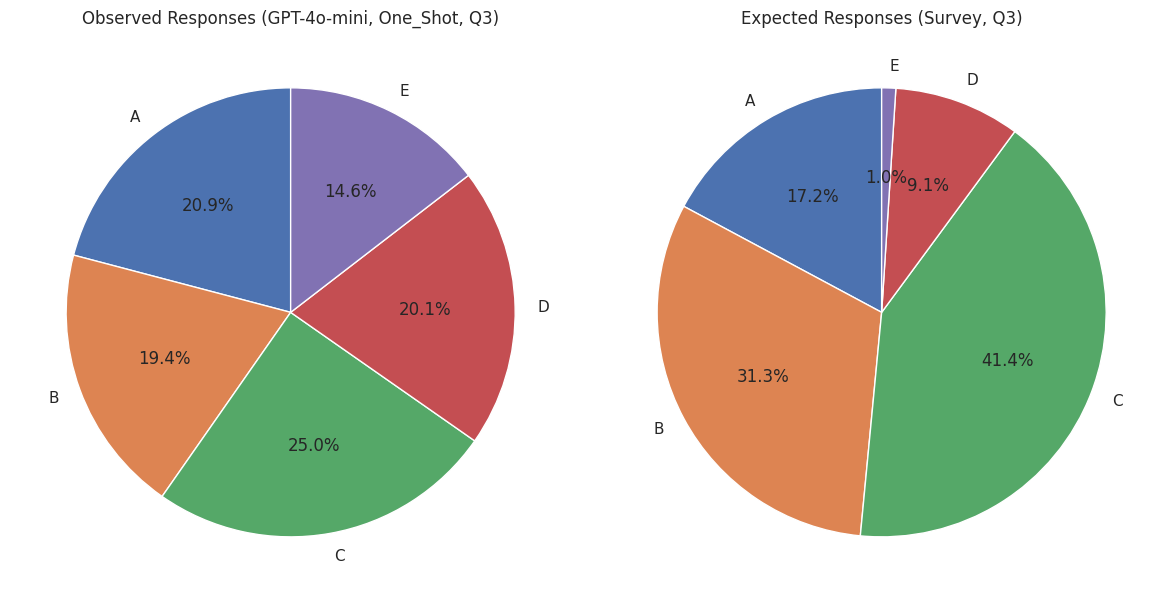


--- Results for GPT-4o-mini, Few_Shot, Question 1 ---
Chi-Square Statistic: 12.4604
P-value: 0.0004156792300682039
Observed Frequencies: [179  89]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


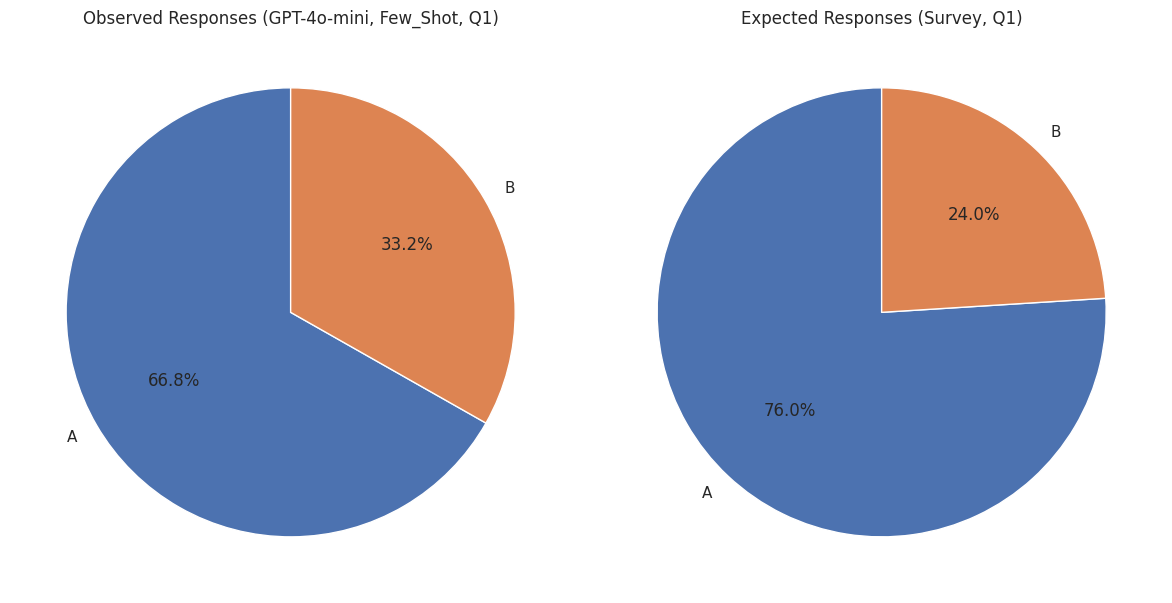


--- Results for GPT-4o-mini, Few_Shot, Question 2 ---
Chi-Square Statistic: 12.4726
P-value: 0.0019570473259360884
Observed Frequencies: [129  75  64]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


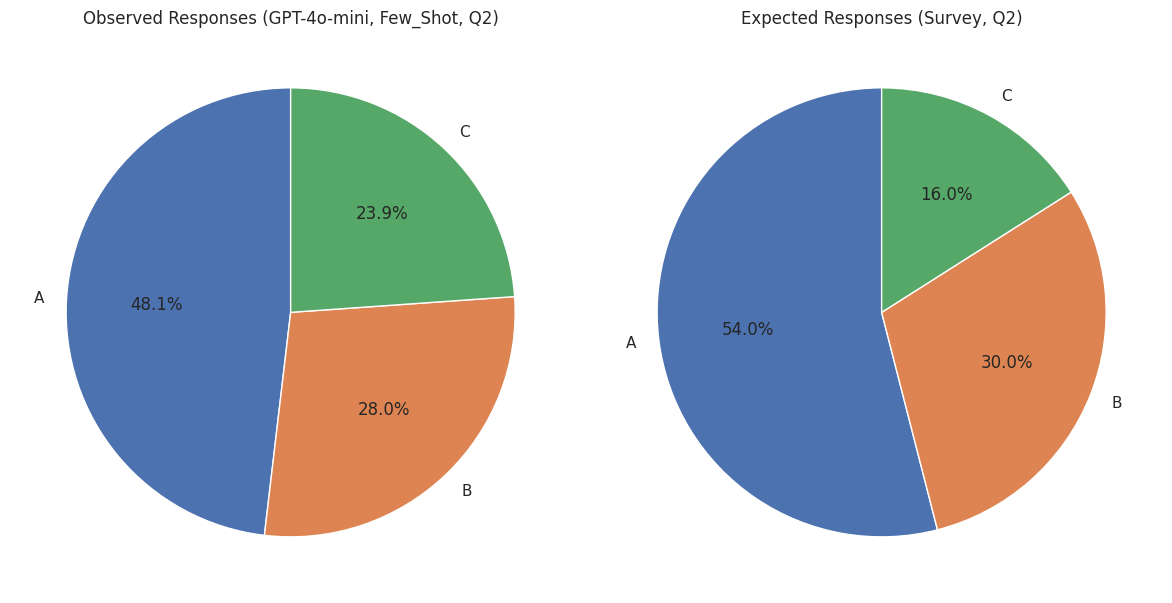


--- Results for GPT-4o-mini, Few_Shot, Question 3 ---
Chi-Square Statistic: 55.4266
P-value: 2.64459989181387e-11
Observed Frequencies: [ 56  52 100  50  10]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


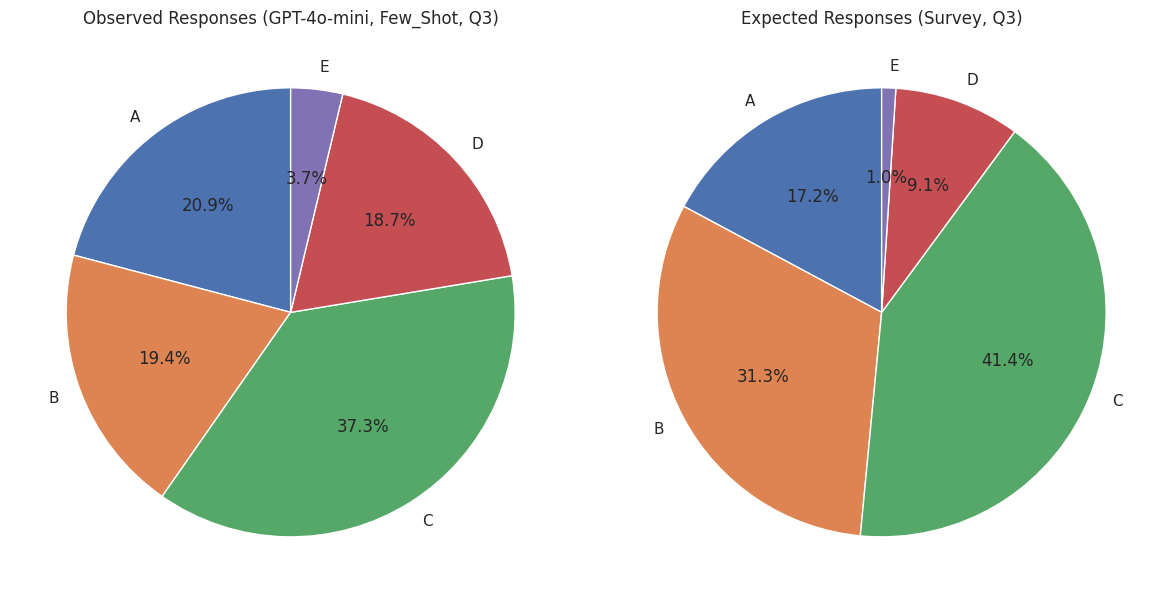


--- Results for Grok-3, Basic_Prompting, Question 1 ---
Chi-Square Statistic: 5.0296
P-value: 0.024917812398703065
Observed Frequencies: [188  80]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


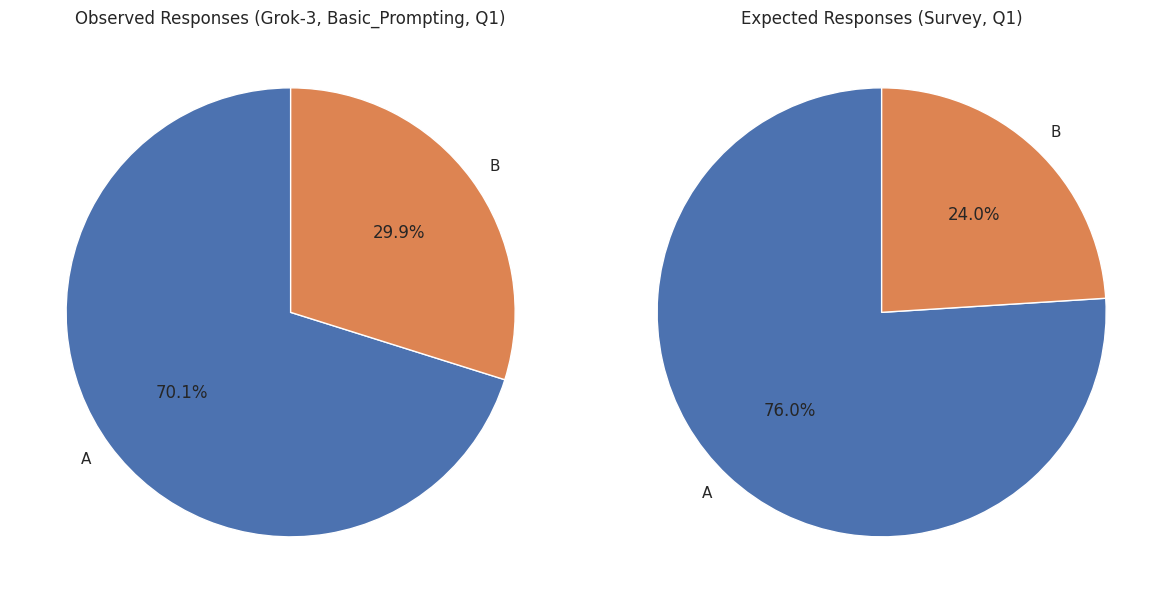


--- Results for Grok-3, Basic_Prompting, Question 2 ---
Chi-Square Statistic: 3.6604
P-value: 0.1603776583097164
Observed Frequencies: [159  67  42]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is not statistically significant.


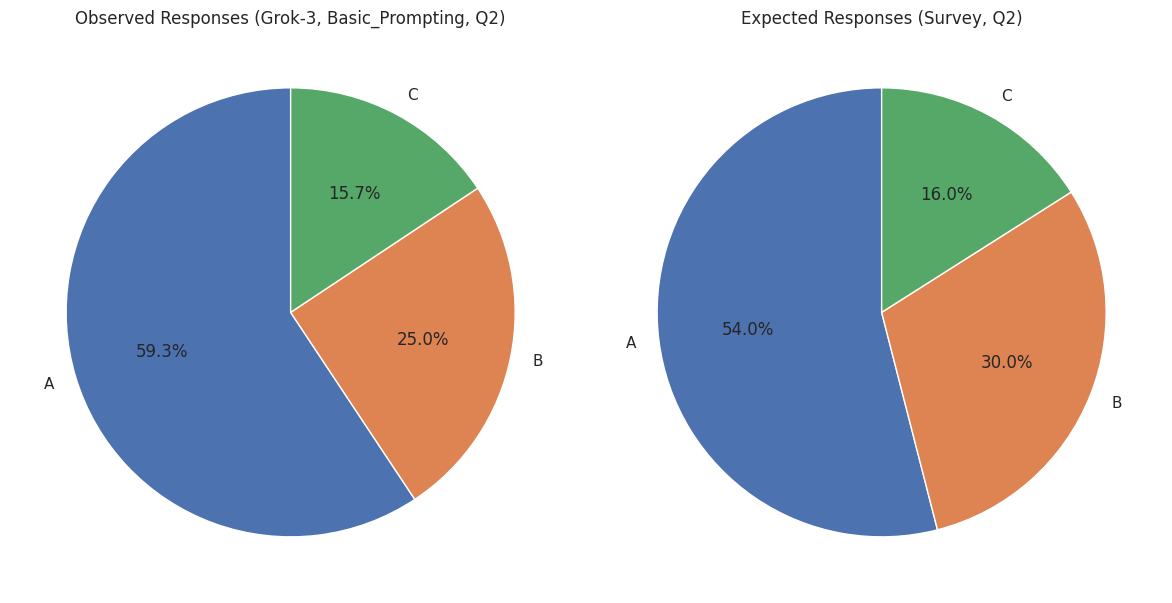


--- Results for Grok-3, Basic_Prompting, Question 3 ---
Chi-Square Statistic: 81.9881
P-value: 6.602291670962944e-17
Observed Frequencies: [ 40  69 110  30  19]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


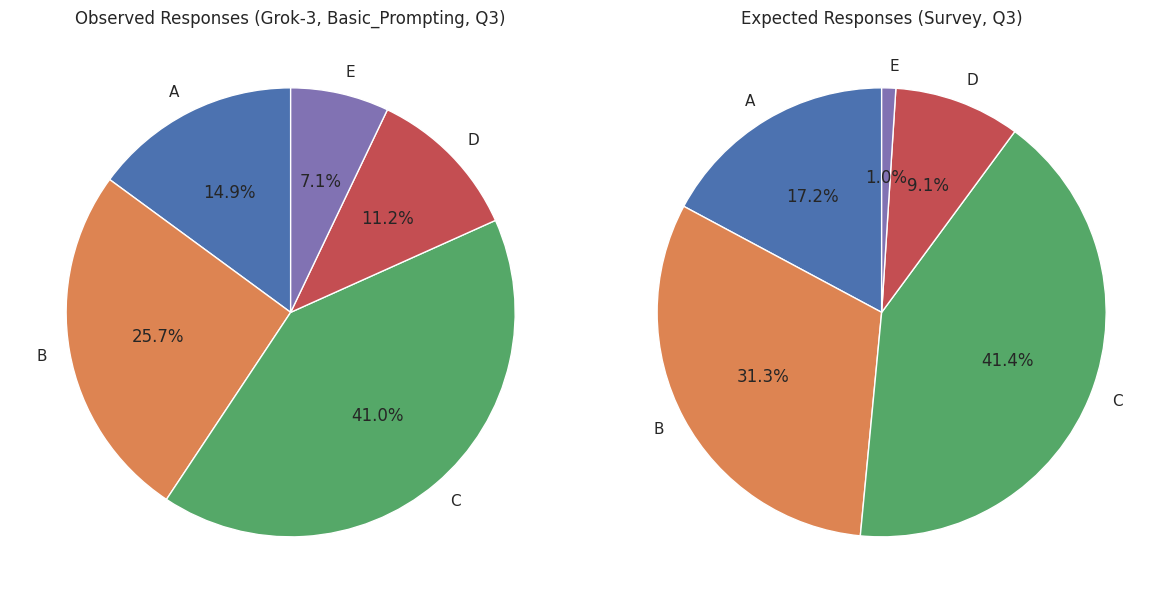


--- Results for Grok-3, Role_Prompting, Question 1 ---
Chi-Square Statistic: 13.4906
P-value: 0.0002397649104982309
Observed Frequencies: [178  90]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


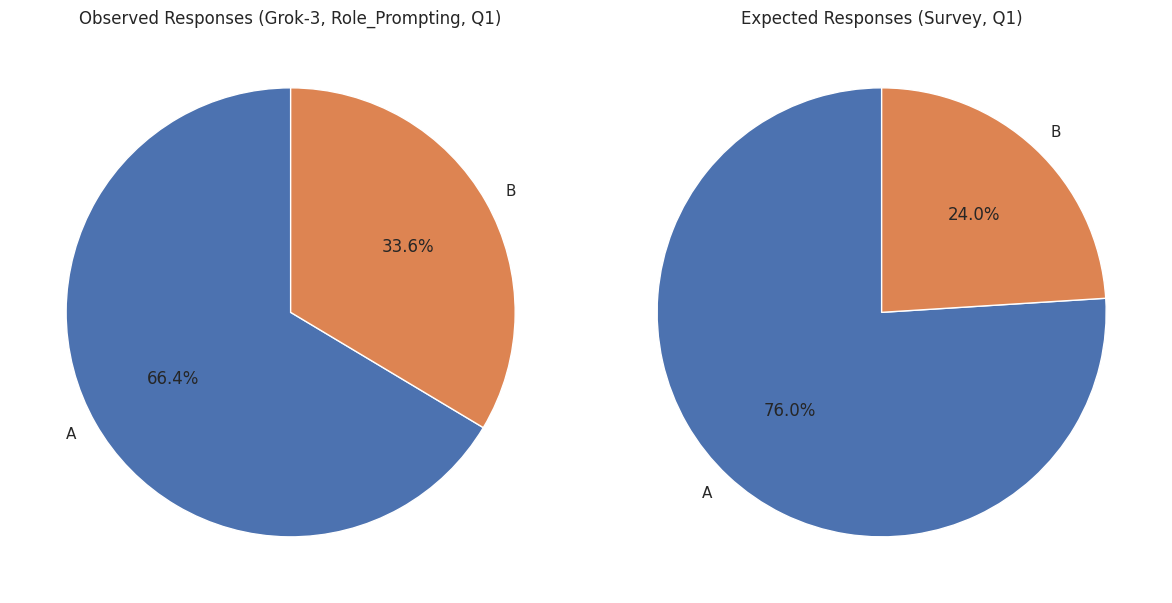


--- Results for Grok-3, Role_Prompting, Question 2 ---
Chi-Square Statistic: 1.5659
P-value: 0.457058940266414
Observed Frequencies: [146  73  49]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is not statistically significant.


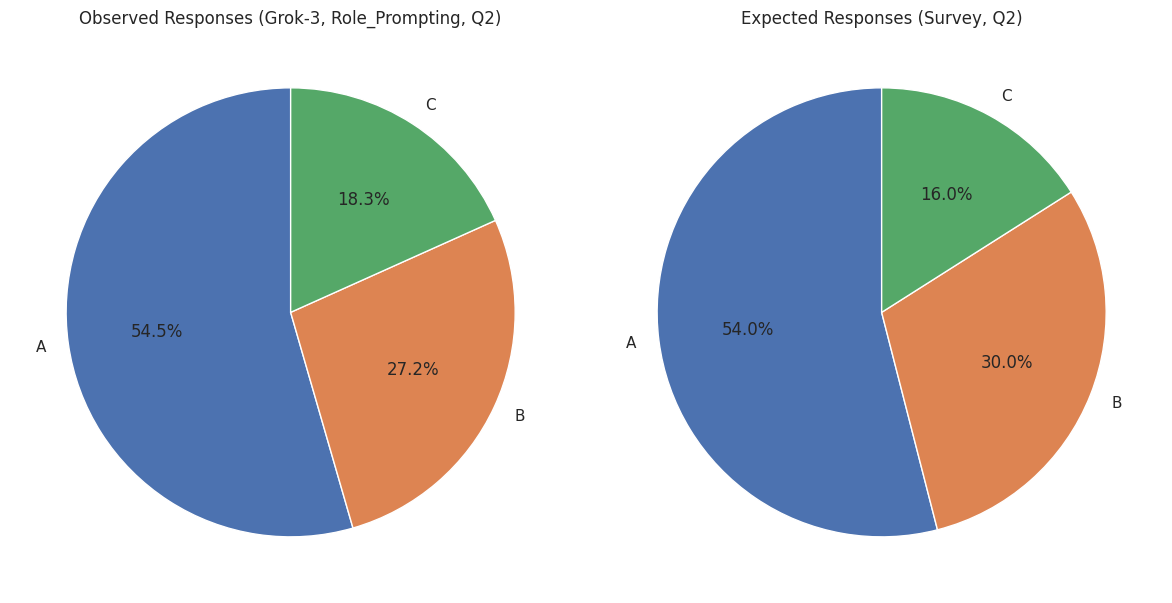


--- Results for Grok-3, Role_Prompting, Question 3 ---
Chi-Square Statistic: 104.1445
P-value: 1.2887531411984595e-21
Observed Frequencies: [43 75 96 33 21]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


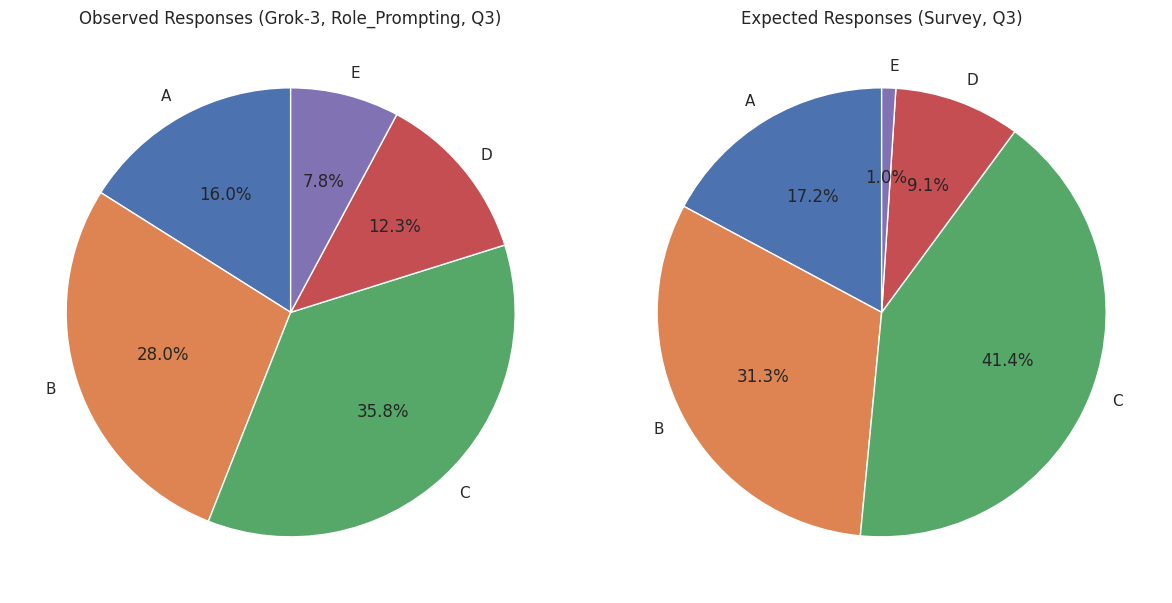


--- Results for Grok-3, One_Shot, Question 1 ---
Chi-Square Statistic: 26.0429
P-value: 3.3390706978273966e-07
Observed Frequencies: [168 100]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


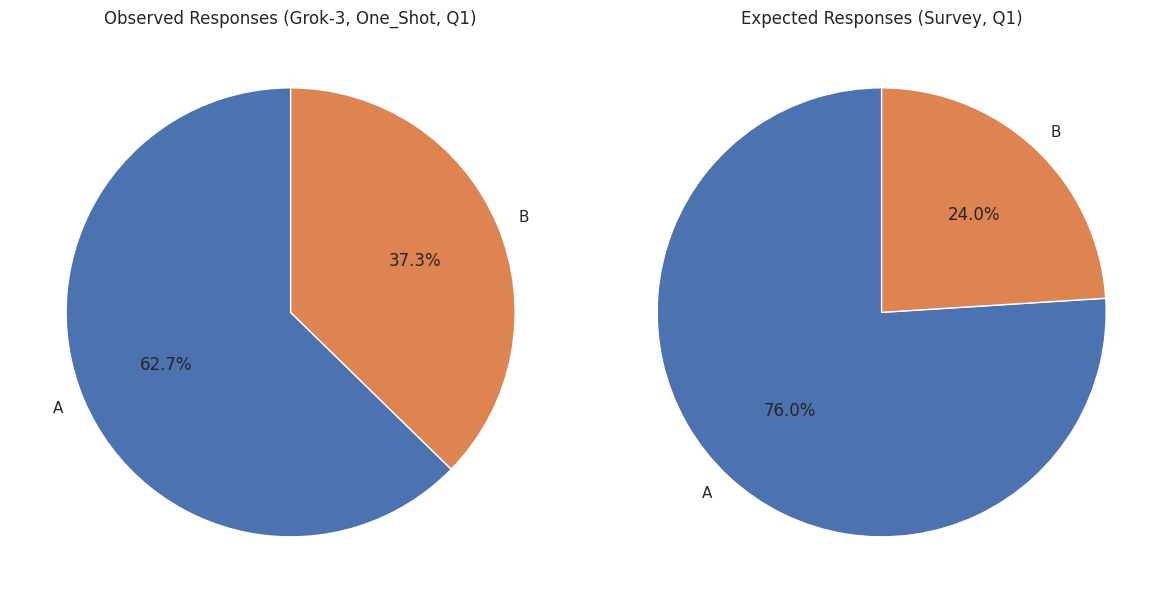


--- Results for Grok-3, One_Shot, Question 2 ---
Chi-Square Statistic: 1.5659
P-value: 0.457058940266414
Observed Frequencies: [146  73  49]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is not statistically significant.


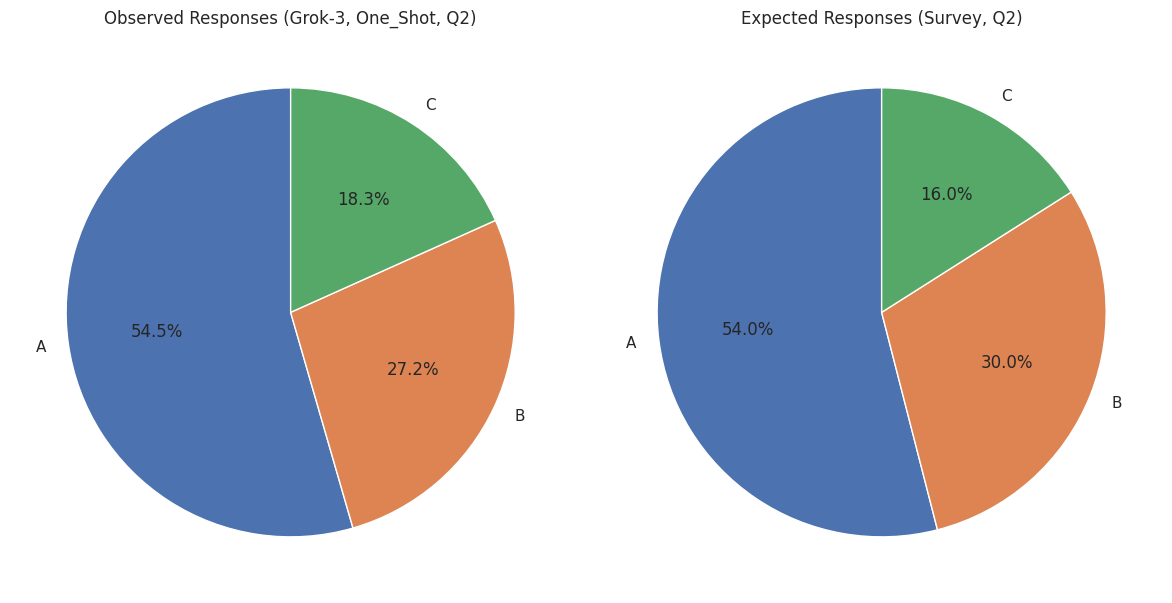


--- Results for Grok-3, One_Shot, Question 3 ---
Chi-Square Statistic: 104.1445
P-value: 1.2887531411984595e-21
Observed Frequencies: [43 75 96 33 21]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


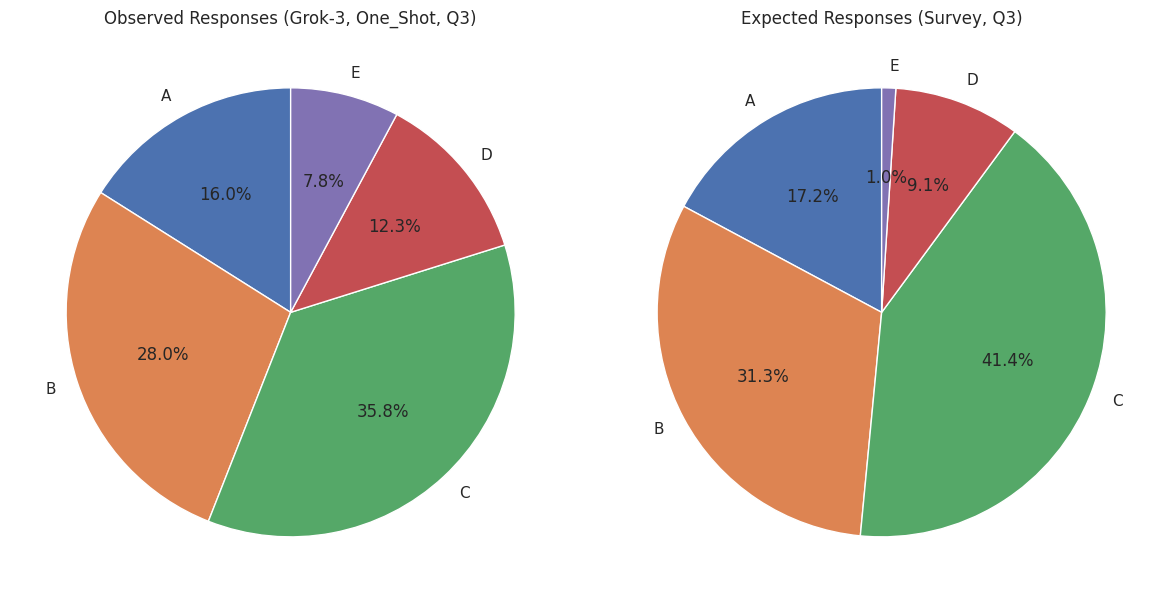


--- Results for Grok-3, Few_Shot, Question 1 ---
Chi-Square Statistic: 7.1383
P-value: 0.007545512672714858
Observed Frequencies: [185  83]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


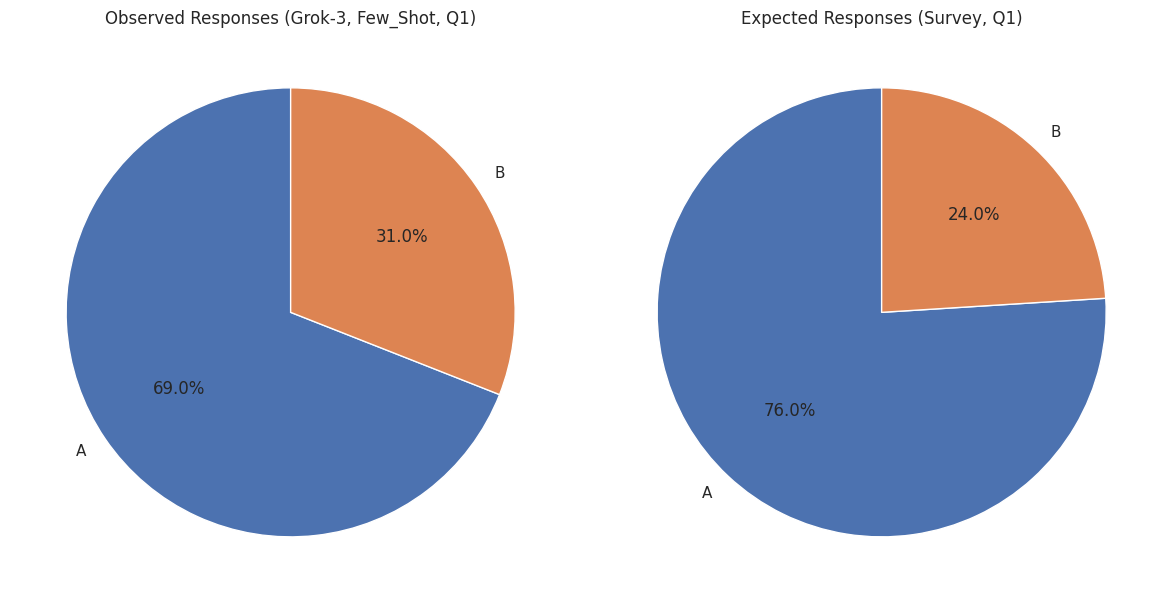


--- Results for Grok-3, Few_Shot, Question 2 ---
Chi-Square Statistic: 1.1321
P-value: 0.5677588013781867
Observed Frequencies: [146  74  48]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is not statistically significant.


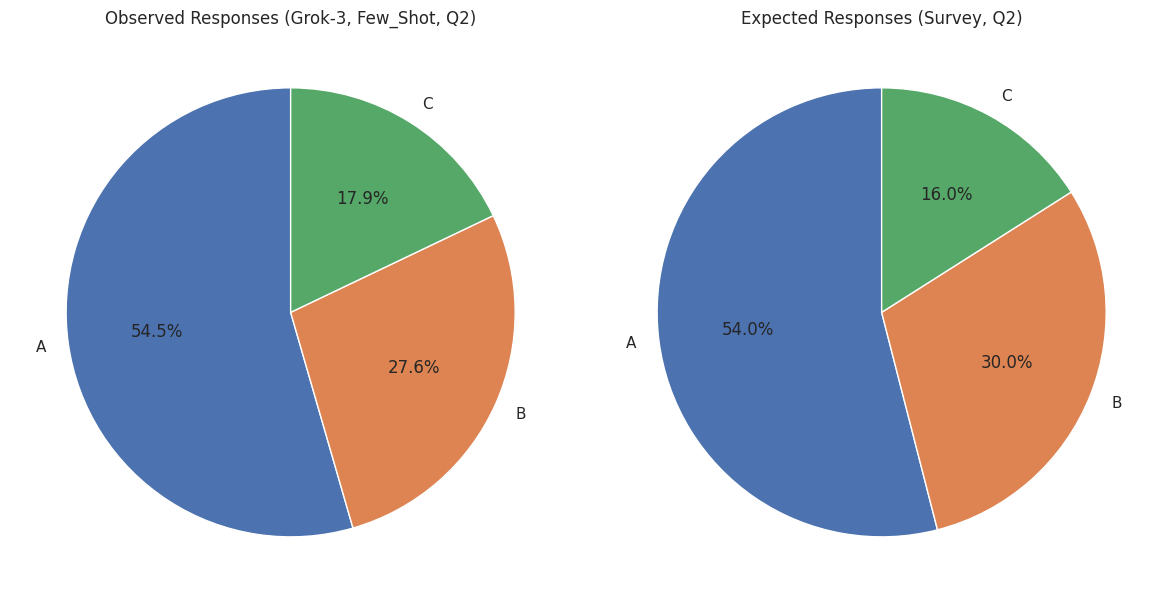


--- Results for Grok-3, Few_Shot, Question 3 ---
Chi-Square Statistic: 1.5515
P-value: 0.6704279883765236
Observed Frequencies: [ 54  81 106  27]
Expected Frequencies: [np.float64(46.900000000000006), np.float64(84.42), np.float64(111.22), np.float64(25.46)]
The difference is not statistically significant.


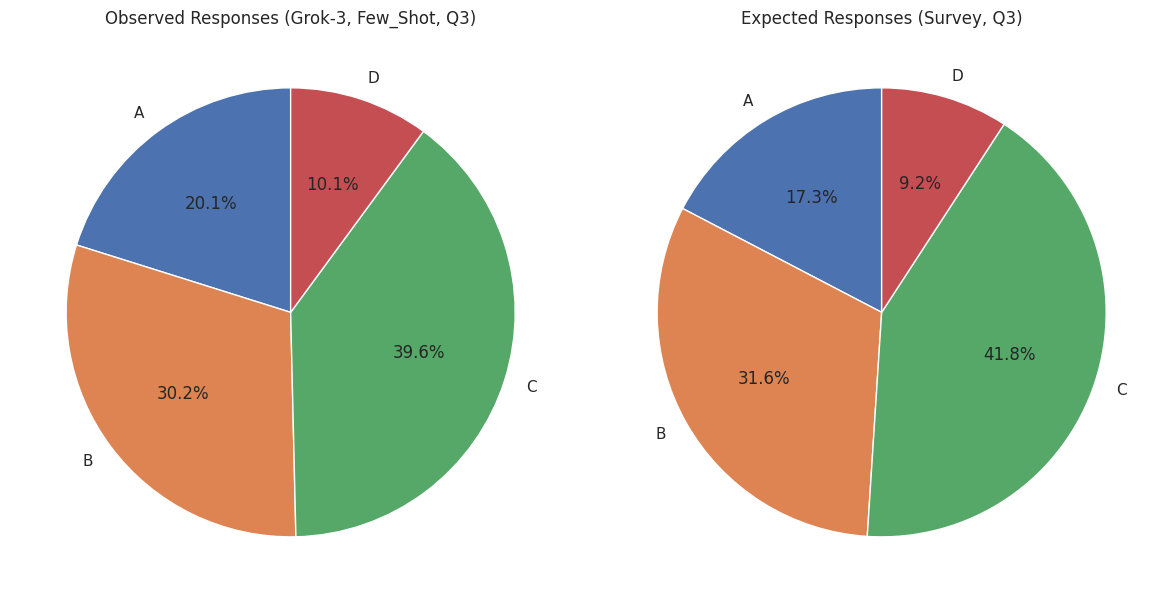


--- Results for Gemini-2.0-Pro, Basic_Prompting, Question 1 ---
Chi-Square Statistic: 40.8382
P-value: 1.653678954040206e-10
Observed Frequencies: [159 109]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


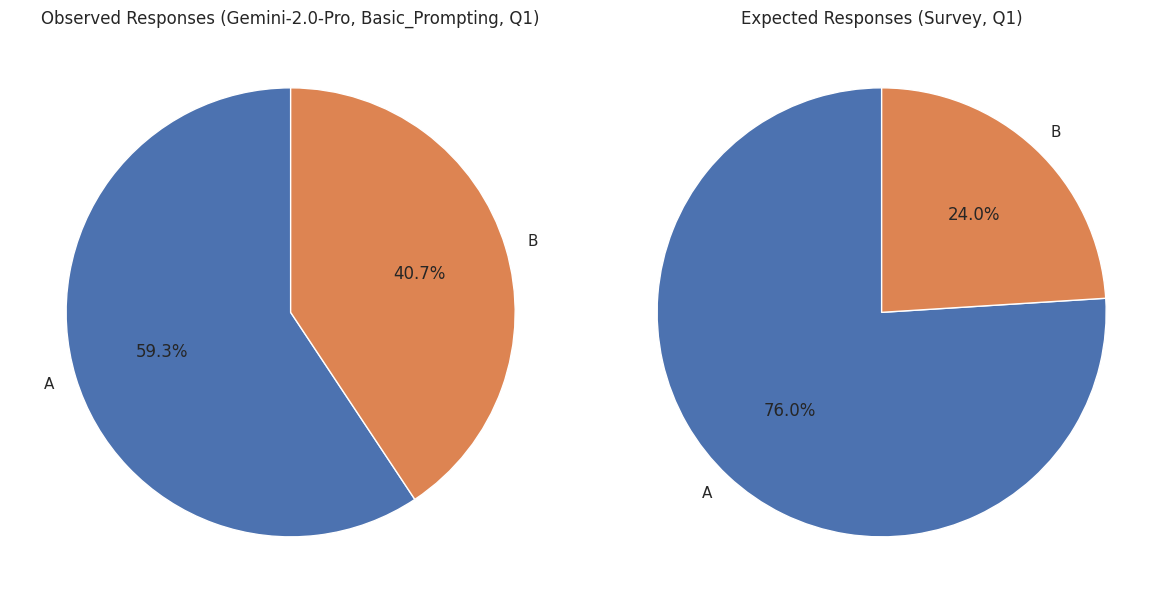


--- Results for Gemini-2.0-Pro, Basic_Prompting, Question 2 ---
Chi-Square Statistic: 12.4213
P-value: 0.002007900916213003
Observed Frequencies: [120  87  61]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


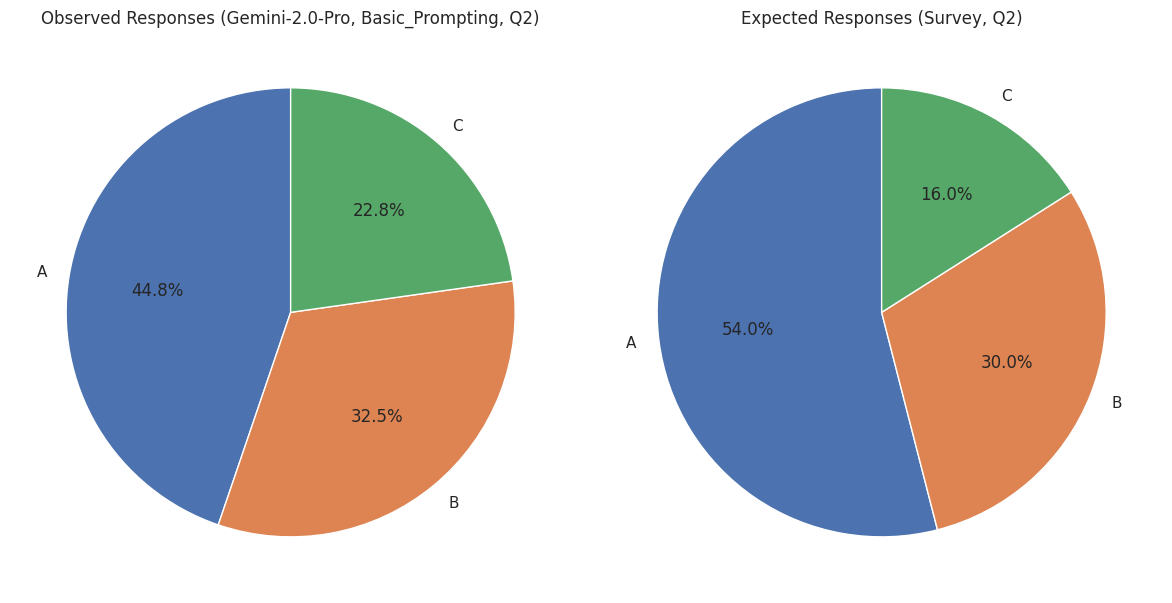


--- Results for Gemini-2.0-Pro, Basic_Prompting, Question 3 ---
Chi-Square Statistic: 119.5704
P-value: 6.59796116973252e-25
Observed Frequencies: [ 46  56 116  28  22]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


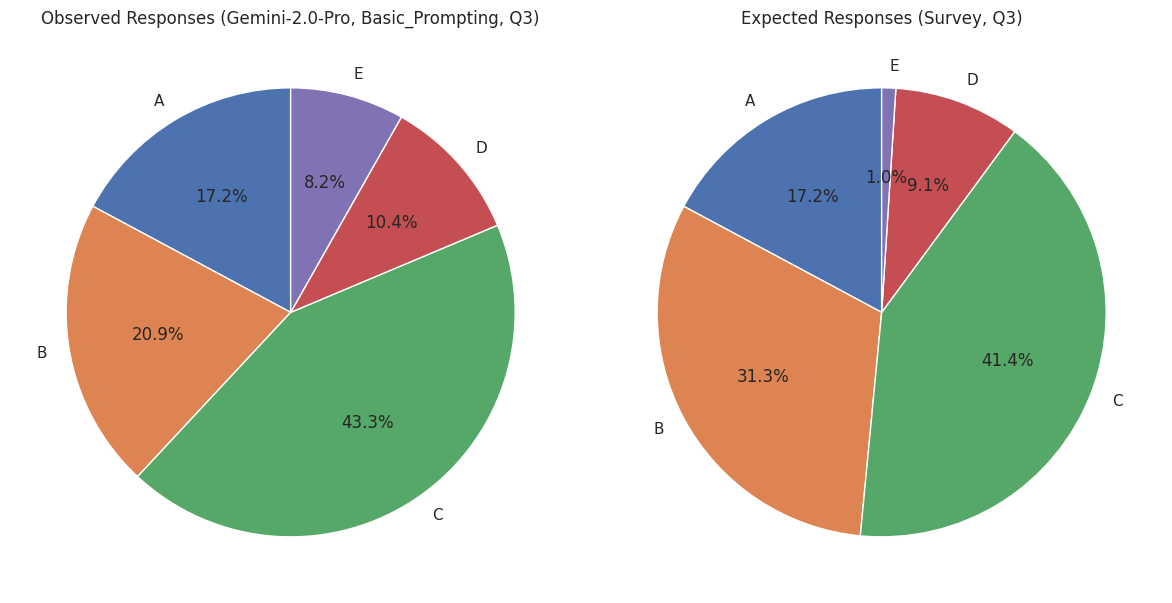


--- Results for Gemini-2.0-Pro, Role_Prompting, Question 1 ---
Chi-Square Statistic: 12.4604
P-value: 0.0004156792300682039
Observed Frequencies: [179  89]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


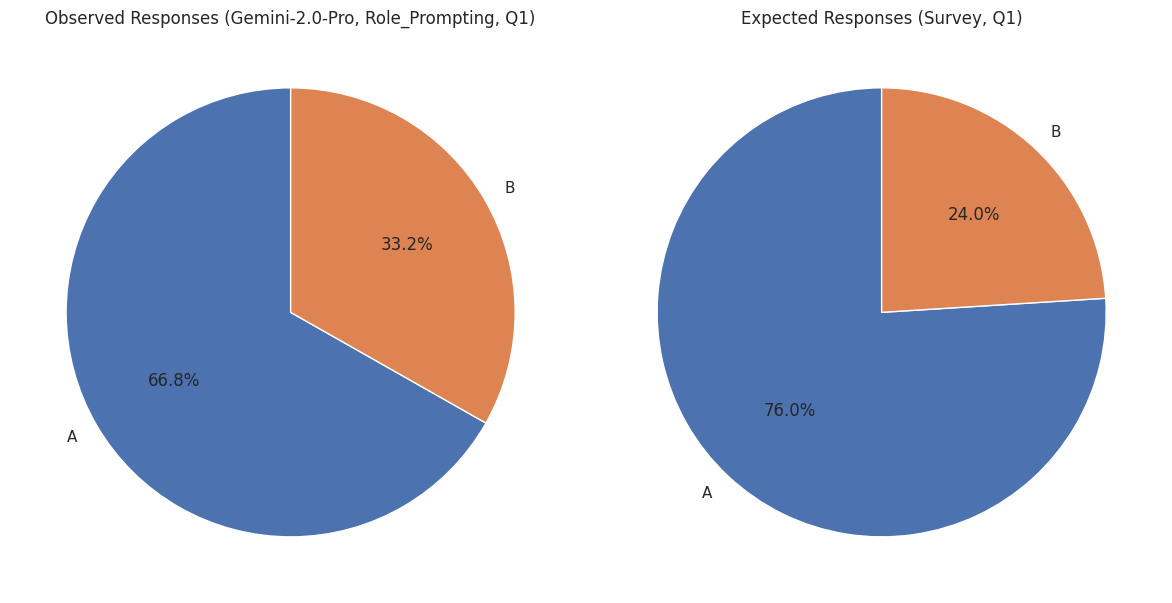


--- Results for Gemini-2.0-Pro, Role_Prompting, Question 2 ---
Chi-Square Statistic: 27.8553
P-value: 8.939320021228423e-07
Observed Frequencies: [185  64  19]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


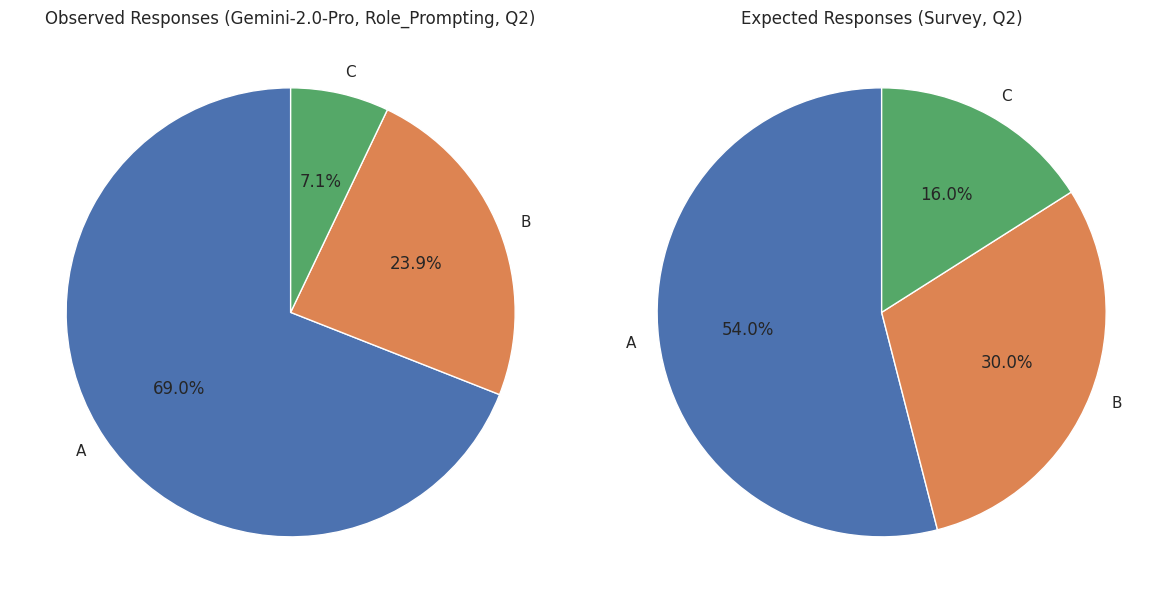


--- Results for Gemini-2.0-Pro, Role_Prompting, Question 3 ---
Chi-Square Statistic: 50.8921
P-value: 2.351146685707739e-10
Observed Frequencies: [ 67  56 126   8  11]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


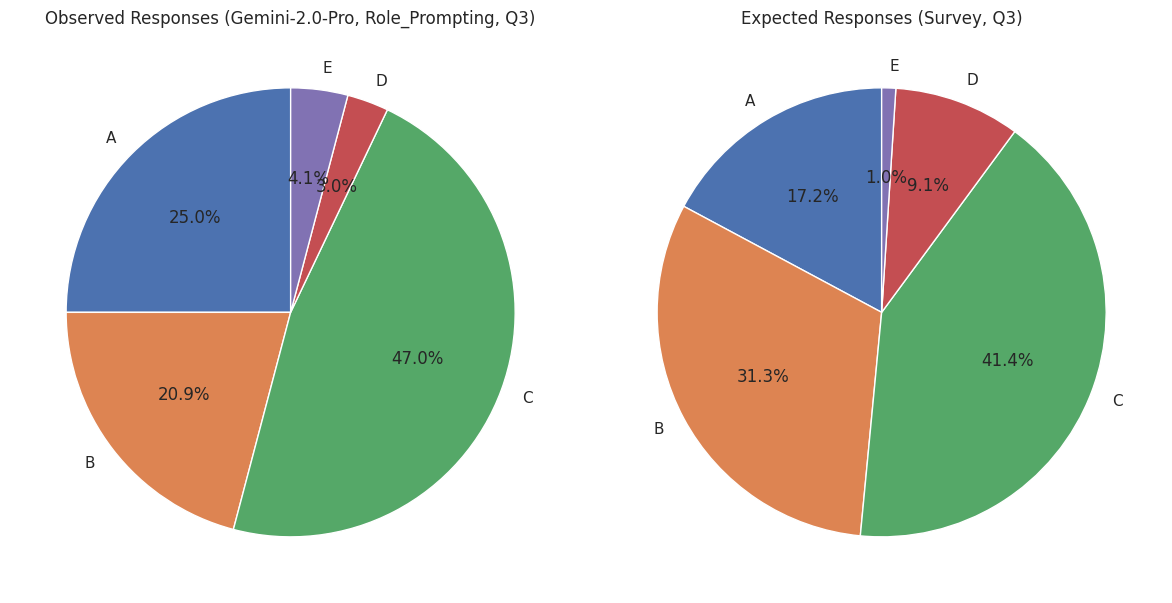


--- Results for Gemini-2.0-Pro, One_Shot, Question 1 ---
Chi-Square Statistic: 44.5761
P-value: 2.4466013691812253e-11
Observed Frequencies: [157 111]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


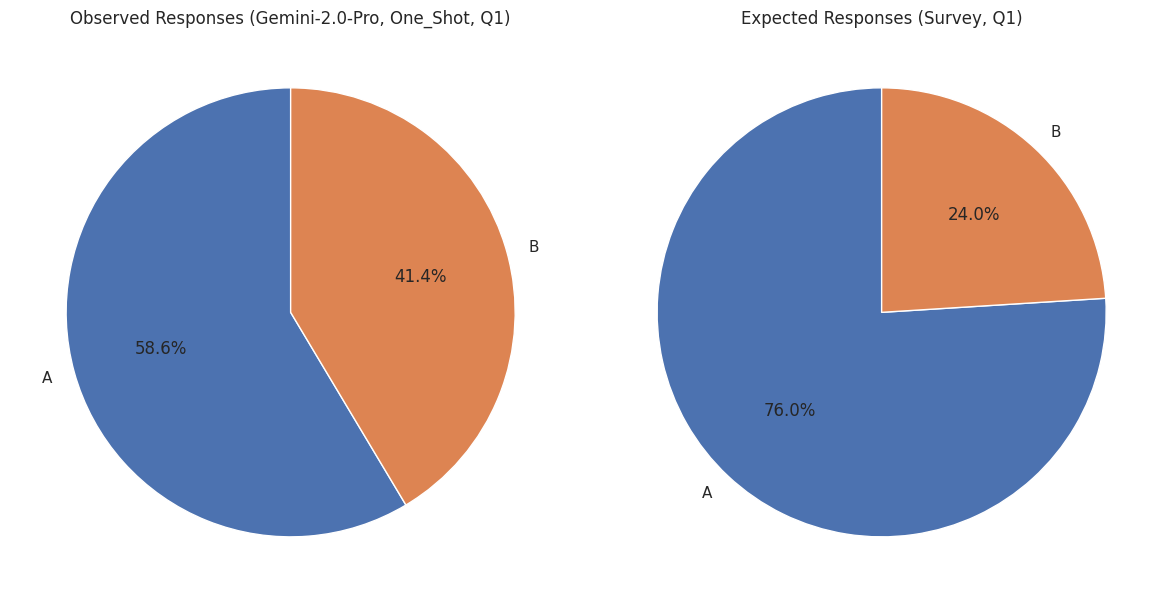


--- Results for Gemini-2.0-Pro, One_Shot, Question 2 ---
Chi-Square Statistic: 4.8800
P-value: 0.08715892421183584
Observed Frequencies: [134  78  56]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is not statistically significant.


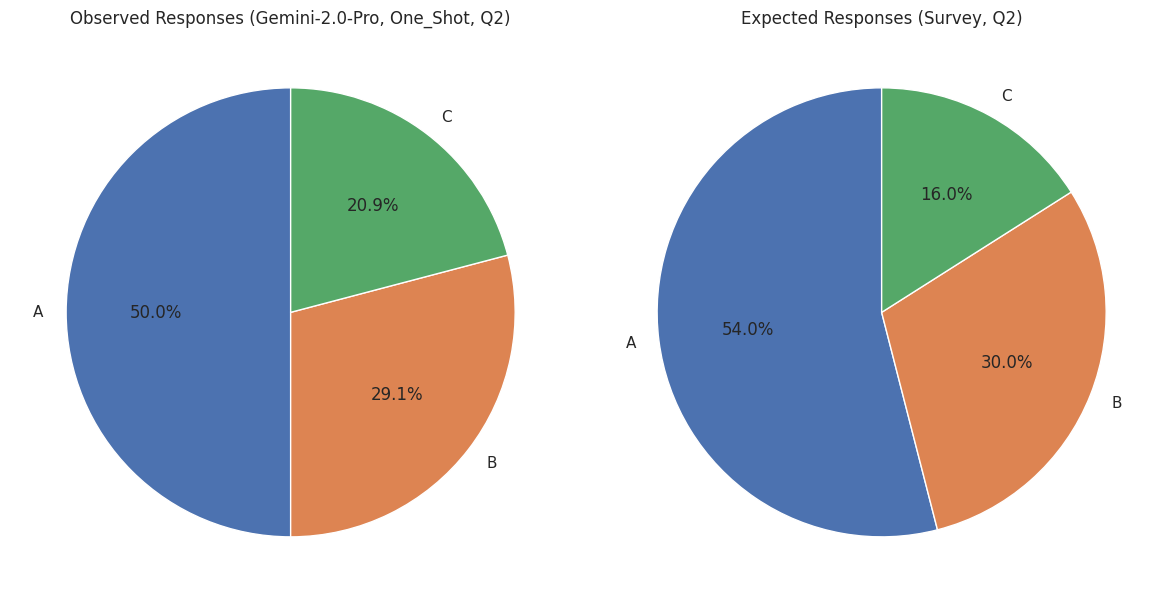


--- Results for Gemini-2.0-Pro, One_Shot, Question 3 ---
Chi-Square Statistic: 146.3875
P-value: 1.2098183752052564e-30
Observed Frequencies: [ 40  44 130  31  23]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


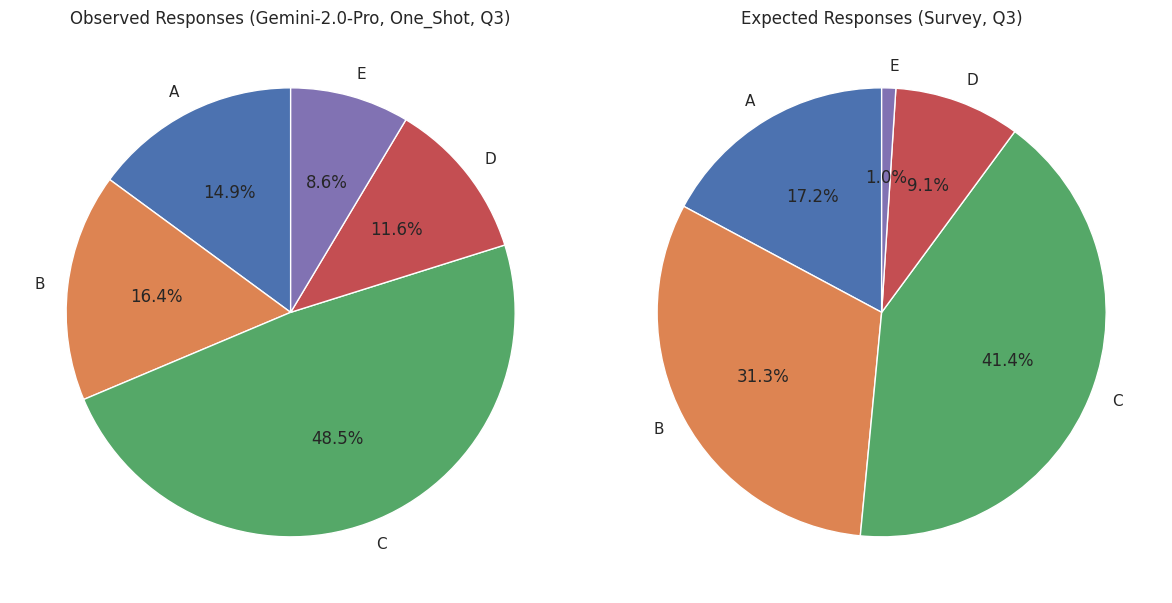


--- Results for Gemini-2.0-Pro, Few_Shot, Question 1 ---
Chi-Square Statistic: 11.1249
P-value: 0.0008517488234911247
Observed Frequencies: [227  41]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


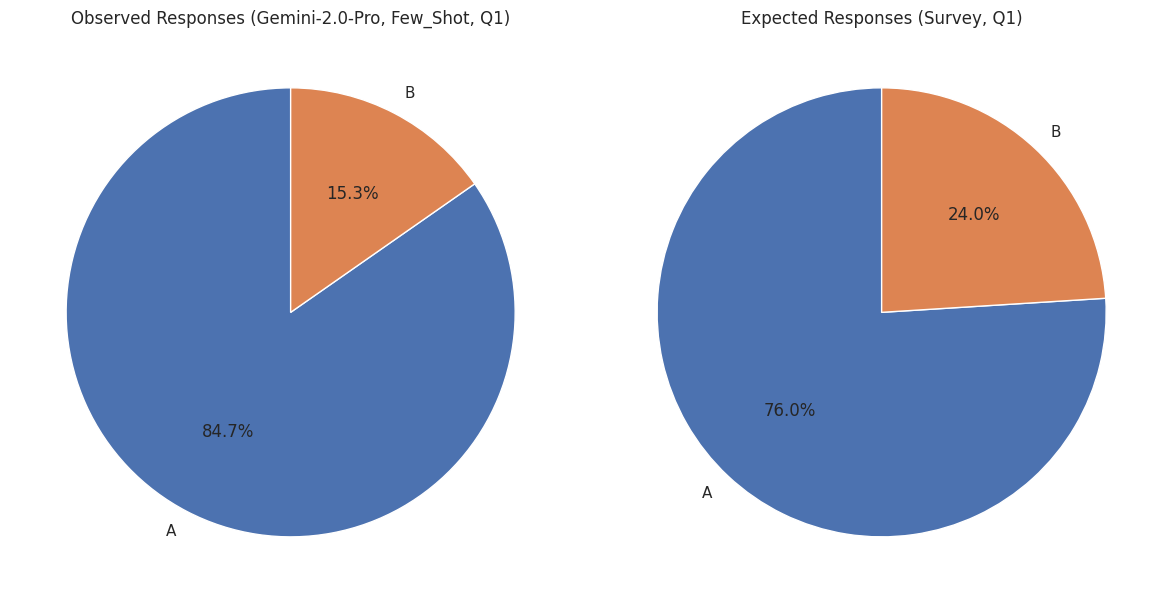


--- Results for Gemini-2.0-Pro, Few_Shot, Question 2 ---
Chi-Square Statistic: 87.4697
P-value: 1.0143689668410551e-19
Observed Frequencies: [221  32  15]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


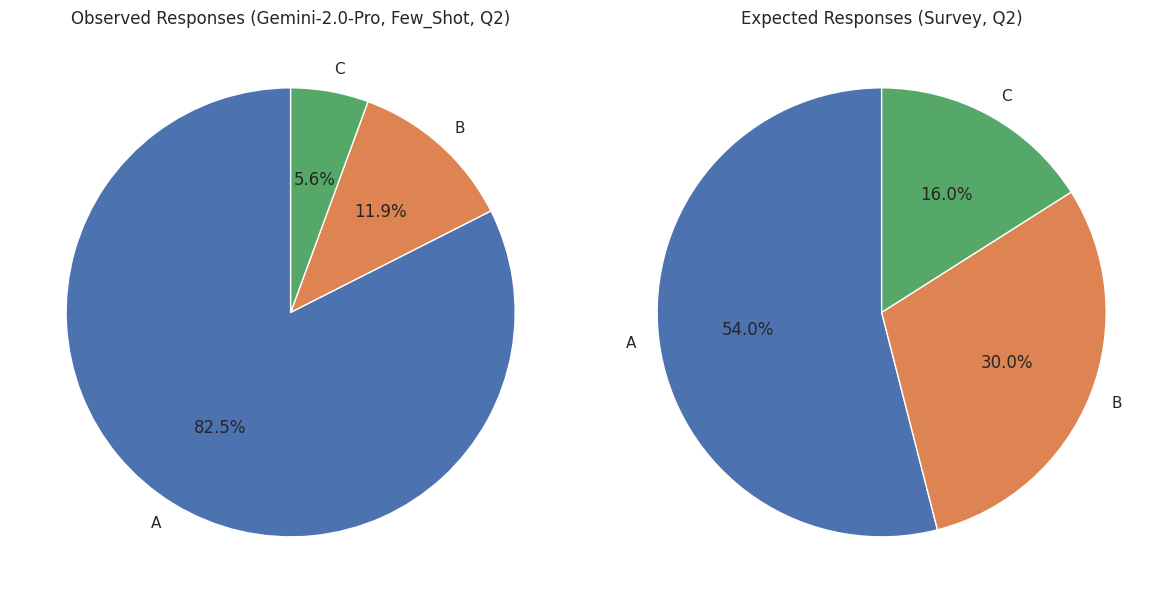


--- Results for Gemini-2.0-Pro, Few_Shot, Question 3 ---
Chi-Square Statistic: 133.9294
P-value: 5.621794733288326e-28
Observed Frequencies: [ 48  54 112  31  23]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


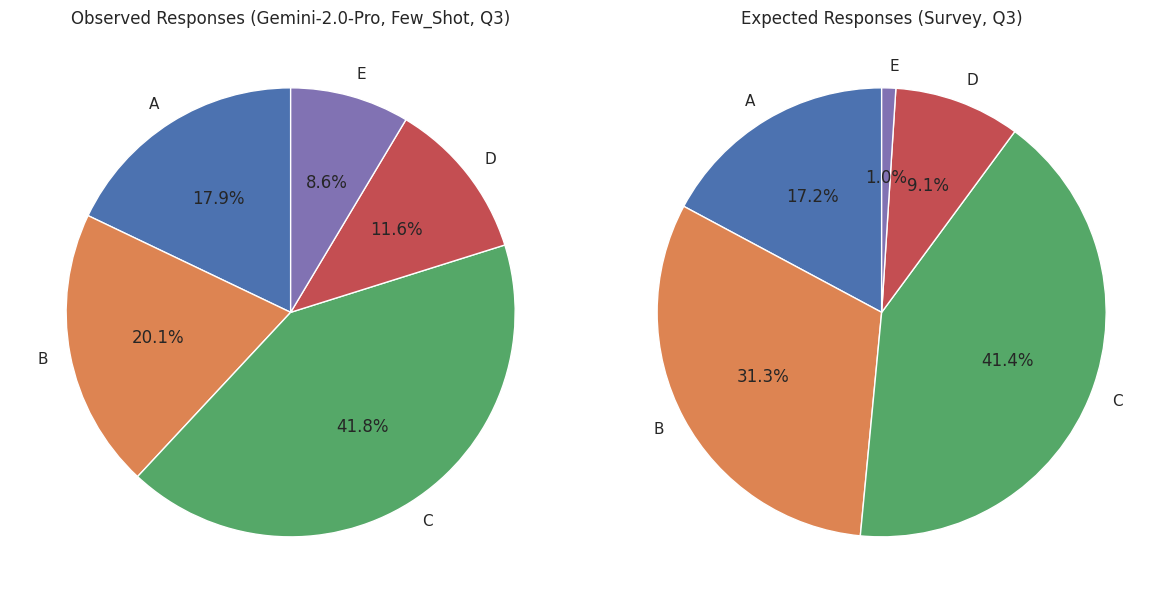


--- Results for Copilot, Basic_Prompting, Question 1 ---
Chi-Square Statistic: 52.5428
P-value: 4.2096361952091024e-13
Observed Frequencies: [153 115]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


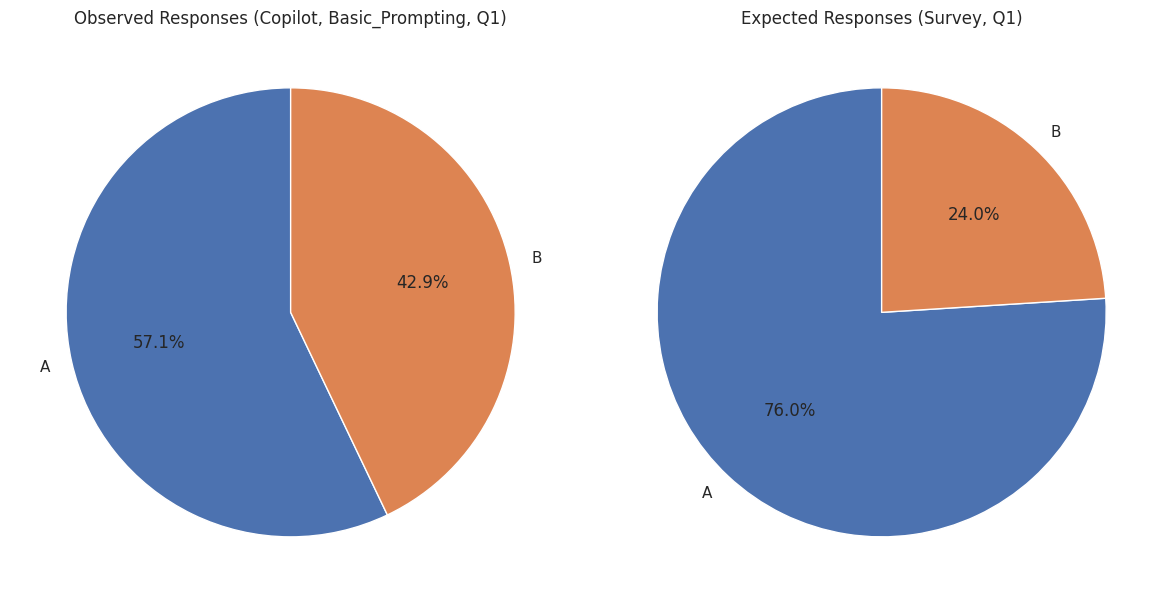


--- Results for Copilot, Basic_Prompting, Question 2 ---
Chi-Square Statistic: 25.4050
P-value: 3.043471519641532e-06
Observed Frequencies: [122  73  73]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


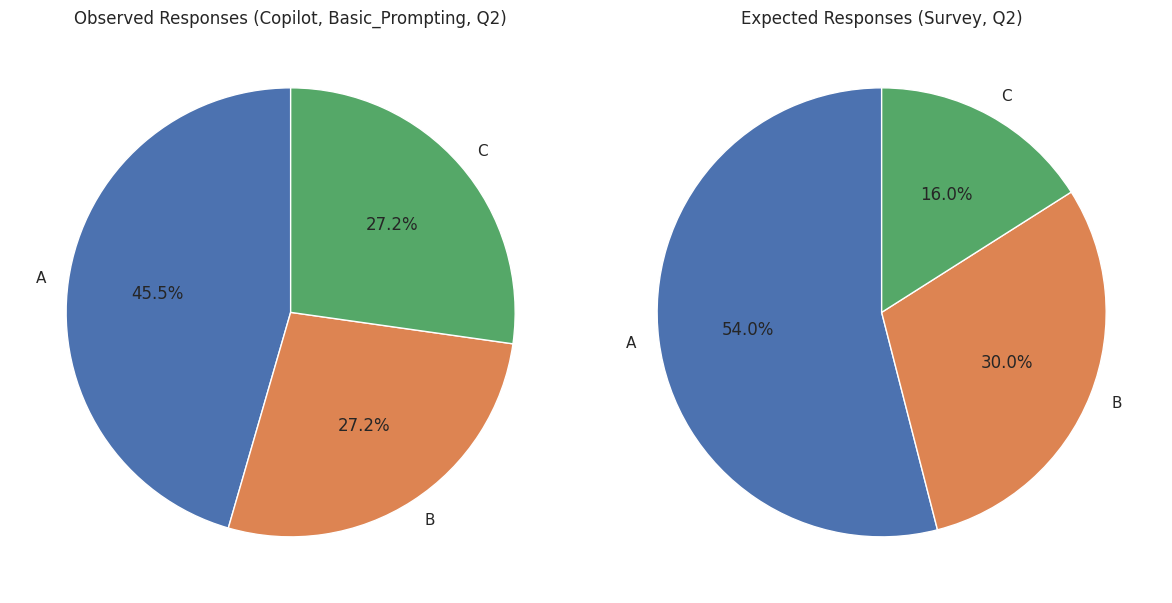


--- Results for Copilot, Basic_Prompting, Question 3 ---
Chi-Square Statistic: 938.2316
P-value: 8.665655094118894e-202
Observed Frequencies: [50 56 53 53 56]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


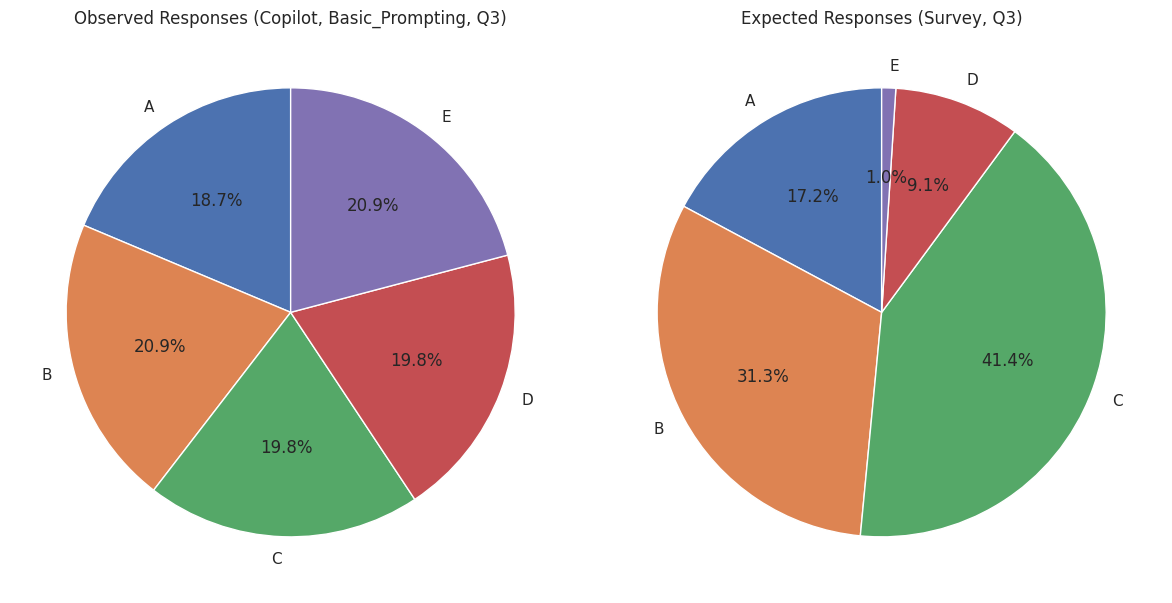


--- Results for Copilot, Role_Prompting, Question 1 ---
Chi-Square Statistic: 5.0296
P-value: 0.024917812398703065
Observed Frequencies: [188  80]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


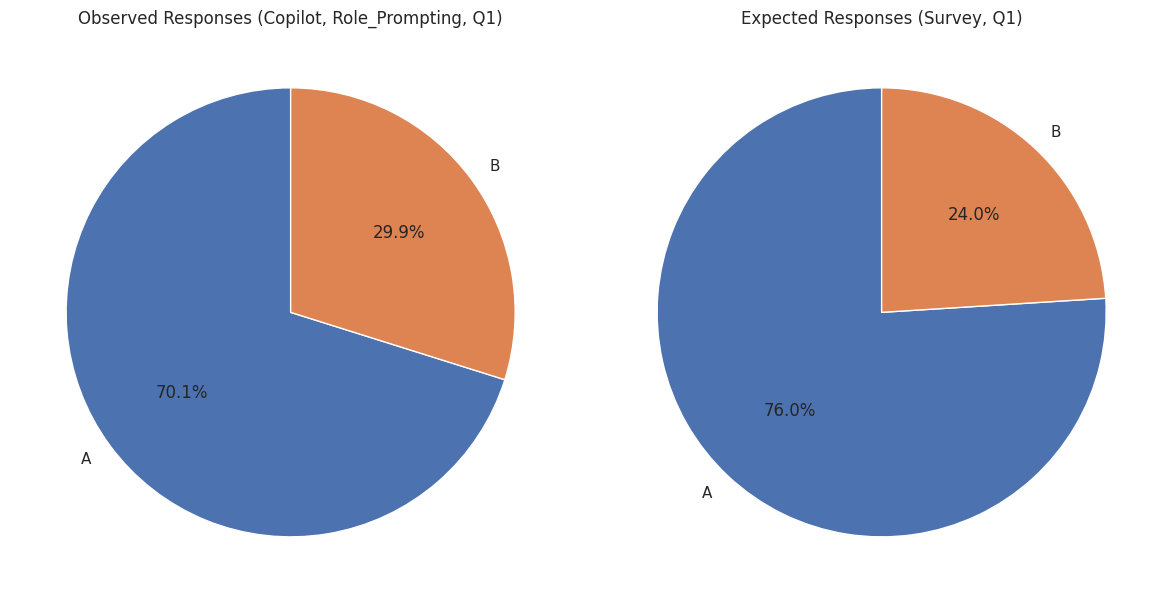


--- Results for Copilot, Role_Prompting, Question 2 ---
Chi-Square Statistic: 59.3134
P-value: 1.3190209950554163e-13
Observed Frequencies: [93 91 84]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


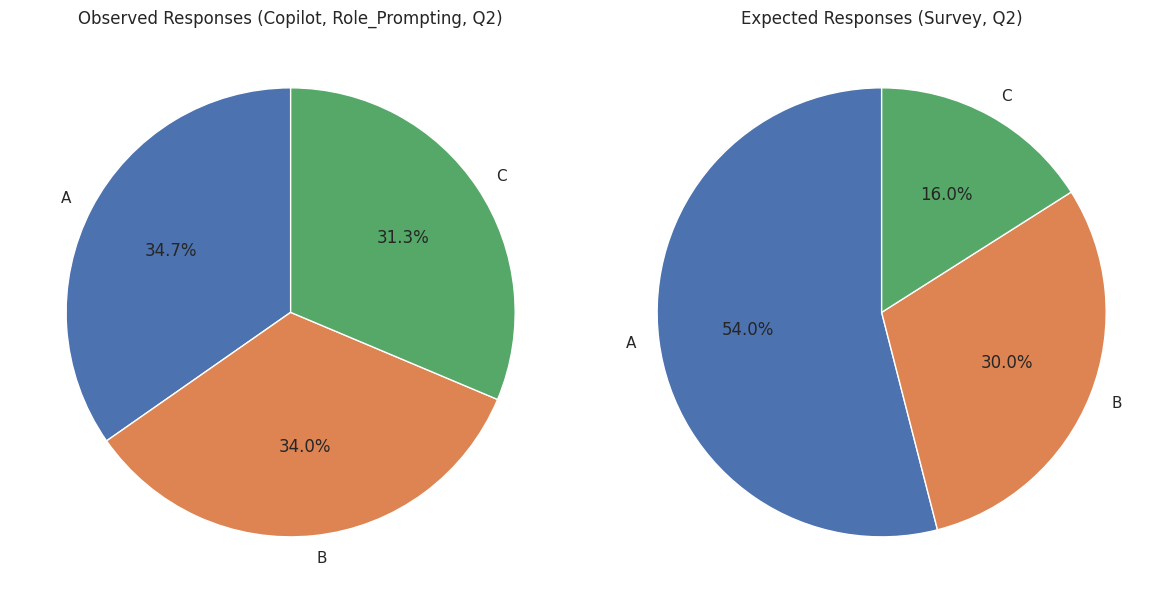


--- Results for Copilot, Role_Prompting, Question 3 ---
Chi-Square Statistic: 872.9277
P-value: 1.2220988352863397e-187
Observed Frequencies: [54 54 54 52 54]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


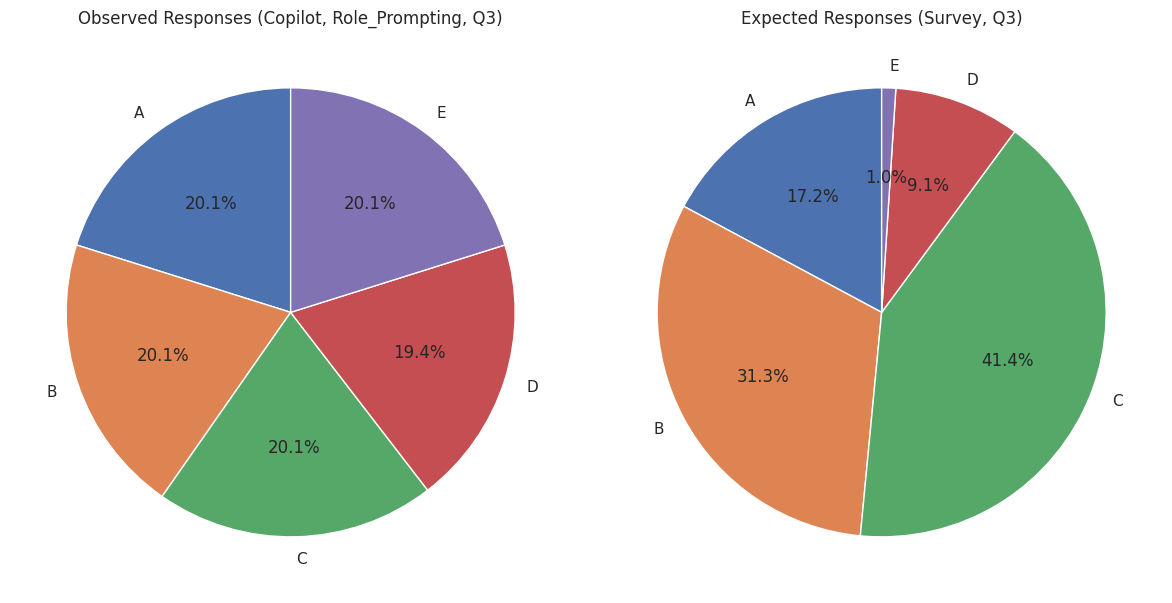


--- Results for Copilot, One_Shot, Question 1 ---
Chi-Square Statistic: 82.9557
P-value: 8.391101565823556e-20
Observed Frequencies: [140 128]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


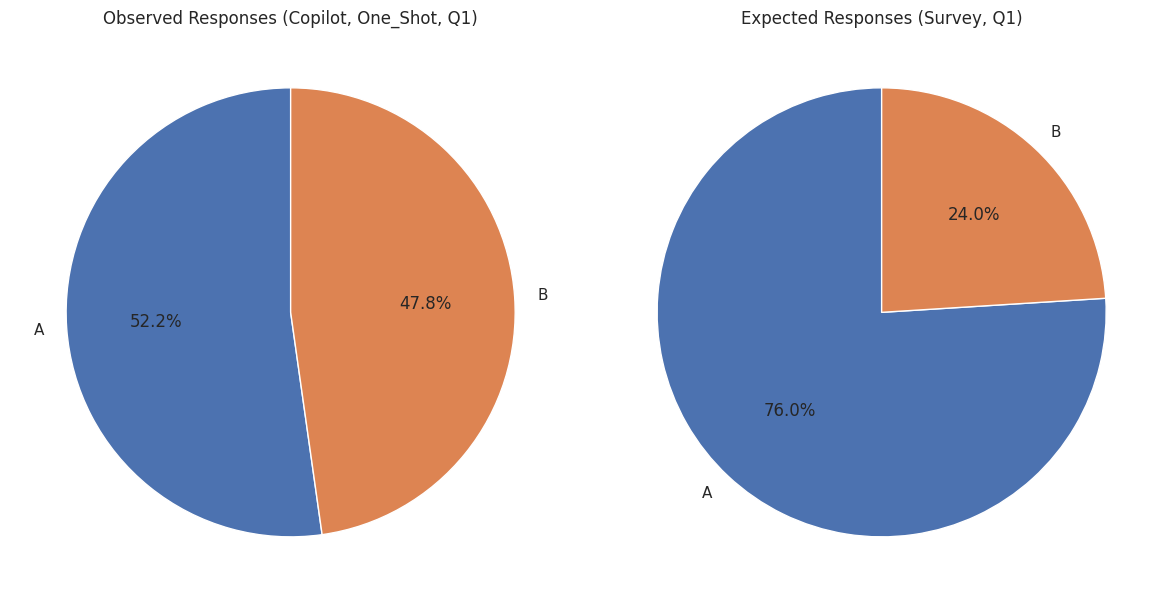


--- Results for Copilot, One_Shot, Question 2 ---
Chi-Square Statistic: 82.5609
P-value: 1.1806631968362356e-18
Observed Frequencies: [92 81 95]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


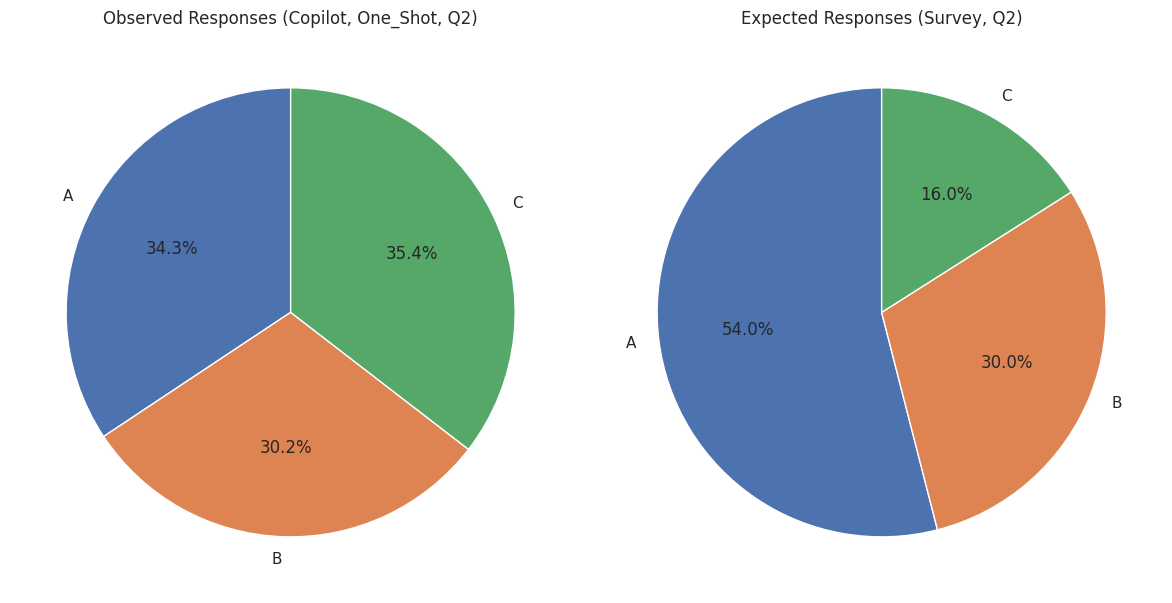


--- Results for Copilot, One_Shot, Question 3 ---
Chi-Square Statistic: 842.0212
P-value: 6.063895959830902e-181
Observed Frequencies: [55 54 54 52 53]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


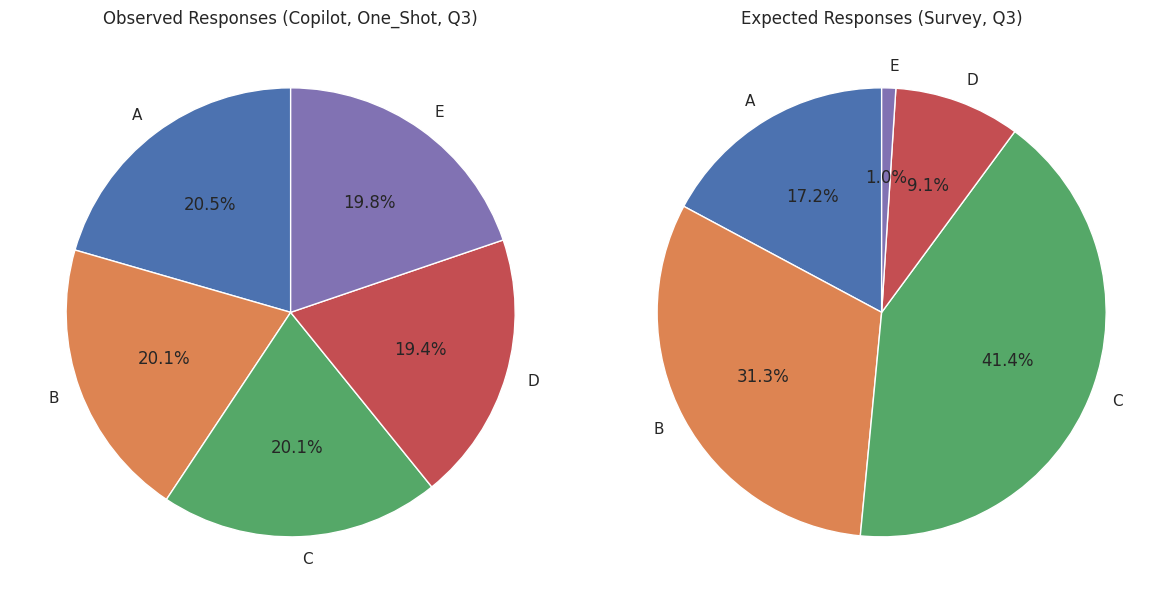


--- Results for Copilot, Few_Shot, Question 1 ---
Chi-Square Statistic: 102.1959
P-value: 5.0294004941401184e-24
Observed Frequencies: [133 135]
Expected Frequencies: [203.68, 64.32]
The difference is statistically significant.


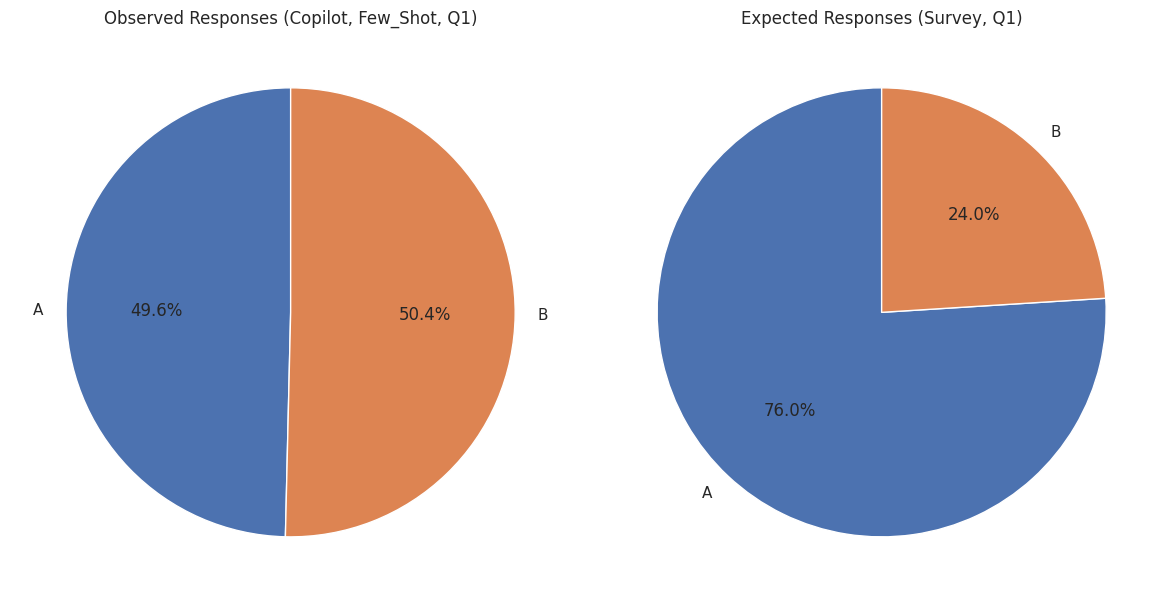


--- Results for Copilot, Few_Shot, Question 2 ---
Chi-Square Statistic: 81.8368
P-value: 1.6958003431170564e-18
Observed Frequencies: [93 80 95]
Expected Frequencies: [144.72, 80.39999999999999, 42.88]
The difference is statistically significant.


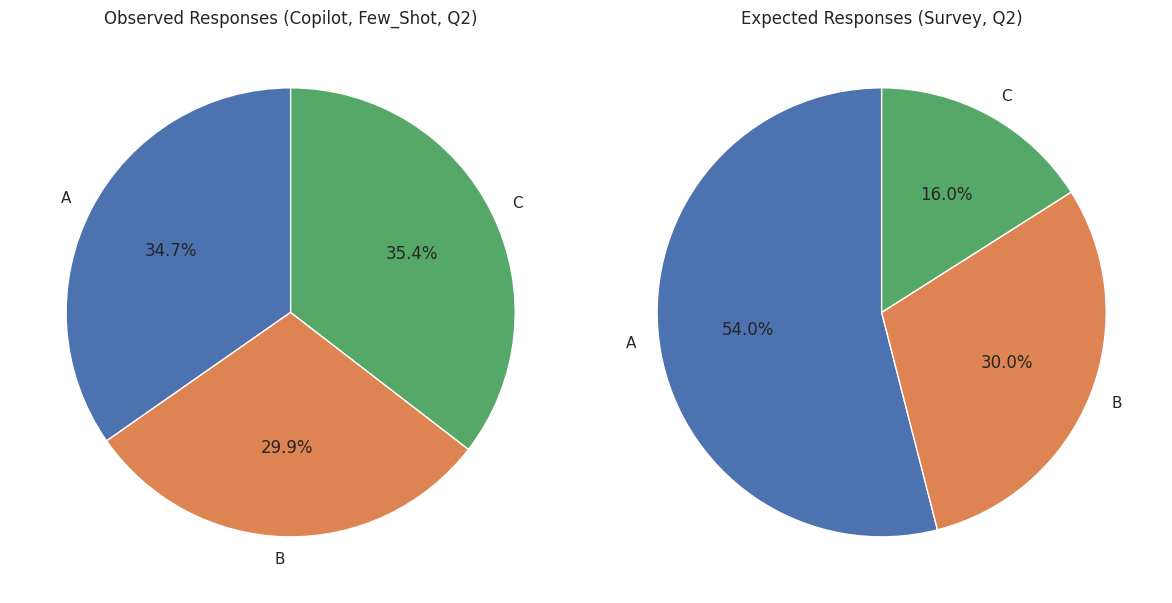


--- Results for Copilot, Few_Shot, Question 3 ---
Chi-Square Statistic: 842.5811
P-value: 4.586260943079516e-181
Observed Frequencies: [53 54 55 53 53]
Expected Frequencies: [np.float64(46.096000000000004), np.float64(83.616), np.float64(110.416), np.float64(24.656), np.float64(3.2160000000000015)]
The difference is statistically significant.


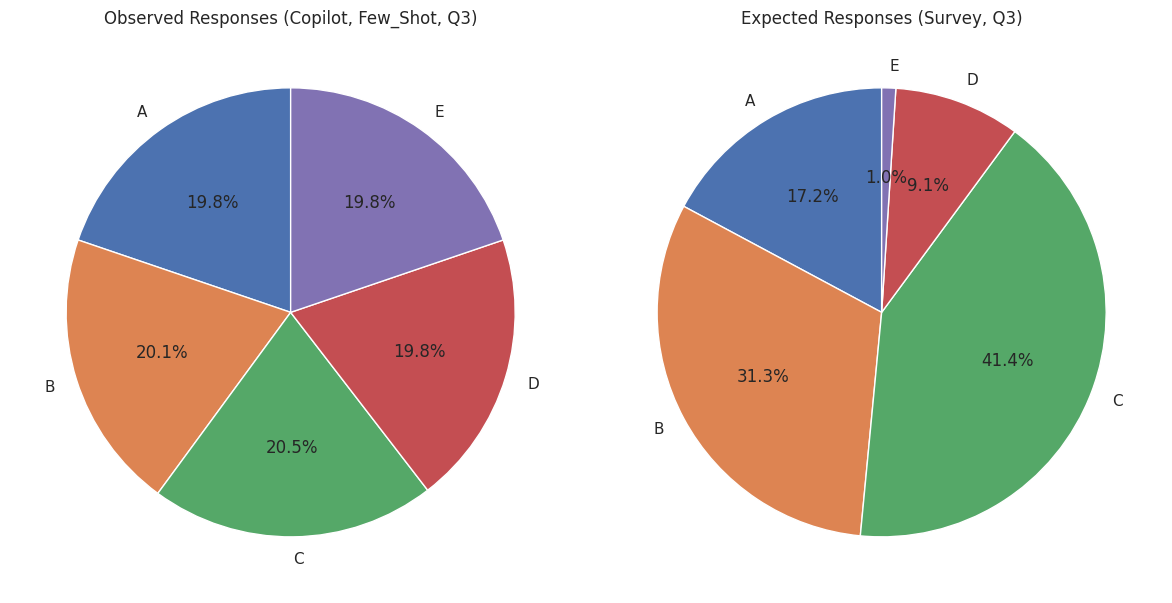

In [21]:
# --- Chi-Square (with Pie Charts) ---
print("Null Hypothesis: The distribution of responses for a given LLM and prompt engineering technique, on a specific question, is the same as the distribution of responses in the human survey for that question. In other words, there is no statistically significant difference between the LLM's responses and the expected frequencies based on the survey. The LLM's responses are consistent with the survey distribution.")
print("Alternative Hypothesis: The distribution of responses for a given LLM and prompt engineering technique, on a specific question, is different from the distribution of responses in the human survey for that question. There is a statistically significant difference between the LLM's responses and the expected frequencies. The LLM's responses are not consistent with the survey distribution.")
print("Using a p value threshold of 0.05, if our results are less than 0.05 it means we can reject the null hypothesis. If our p values are greater than 0.05 we don't reject the null as the observed data is likely to have occurred by chance, given the null hypothesis is true, indicating there is not enough evidence to reject the null hypothesis ")

if df is not None:
    llms = ["GPT-4o-mini","Grok-3","Gemini-2.0-Pro","Copilot"]
    techniques = ["Basic_Prompting","Role_Prompting","One_Shot","Few_Shot"]

    for llm_to_test in llms:
        for technique_to_test in techniques:
          for question_id_to_test in range(1, 4):
            chi2_stat, p_value, observed, expected, observed_labels = calculate_chi_square(
            df, llm_to_test, technique_to_test, question_id_to_test,
            survey_data[question_id_to_test])

            if chi2_stat is not None:
                print(f"\n--- Results for {llm_to_test}, {technique_to_test}, Question {question_id_to_test} ---")
                print(f"Chi-Square Statistic: {chi2_stat:.4f}")
                print(f"P-value: {p_value}")
                print(f"Observed Frequencies: {observed}")
                print(f"Expected Frequencies: {expected}")

                alpha = 0.05
                if p_value <= alpha:
                    print("The difference is statistically significant.")
                else:
                    print("The difference is not statistically significant.")

                # --- Pie Chart Visualization ---
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                # Observed Frequencies Pie Chart
                axes[0].pie(observed, labels=observed_labels, autopct='%1.1f%%', startangle=90)
                axes[0].set_title(f'Observed Responses ({llm_to_test}, {technique_to_test}, Q{question_id_to_test})')

                # Expected Frequencies Pie Chart
                expected_labels = list(survey_data[question_id_to_test].keys())
                filtered_expected_labels = [label for label in expected_labels if label in observed_labels]
                filtered_expected_percentages = [survey_data[question_id_to_test][label] for label in filtered_expected_labels]

                axes[1].pie(filtered_expected_percentages, labels=filtered_expected_labels, autopct='%1.1f%%', startangle=90)
                axes[1].set_title(f'Expected Responses (Survey, Q{question_id_to_test})')

                plt.tight_layout()
                plt.show()
            else:
                print(f"\n--- Results for {llm_to_test}, {technique_to_test}, Question {question_id_to_test} ---")
                print("Chi-Square could not be calculated (likely a data issue).")



# Detailed Analysis of All LLMs per Technique

In [22]:
# --- Main Analysis ---
if df is not None:
    llms_to_test = ["GPT-4o-mini","Grok-3","Gemini-2.0-Pro","Copilot"]
    techniques = df['technique'].unique()
    alpha = 0.05

    for llm in llms_to_test:
        print(f"\n--- Chi-Square Results for LLM: {llm} ---")
        for question_id in range(1, 4):
            print(f"  - Question {question_id}:")

            results = {}
            for technique in techniques:
                chi2_stat, p_value, observed, expected, _ = calculate_chi_square(df, llm, technique, question_id, survey_data[question_id])
                if chi2_stat is not None:
                    results[technique] = (chi2_stat, p_value, observed, expected)
                else:
                    results[technique] = (np.inf, 1.0, None, None)

            sorted_techniques = sorted(results.items(), key=lambda item: item[1][0])

            for technique, (chi2_stat, p_value, observed, expected) in sorted_techniques:
                print(f"    - Technique: {technique}")
                print(f"      Observed Frequencies: {observed}")
                print(f"      Expected Frequencies: {expected}")
                print(f"      Chi-Square = {chi2_stat:.4f}")
                print(f"      P-value = {p_value}")


        print(f"\n--- Euclidean Distance Results for LLM: {llm} ---")
        for question_id in range(1, 4):
            print(f"  - Question {question_id}:")

            results = {}
            for technique in techniques:
                euclidean_dist, observed_percentages, expected_percentages = calculate_euclidean(df, llm, technique, question_id, survey_data[question_id])
                if euclidean_dist is not None:
                    results[technique] = (euclidean_dist, observed_percentages, expected_percentages)
                else:
                    results[technique] = (np.inf, None, None)

            sorted_techniques = sorted(results.items(), key=lambda item: item[1][0])

            for technique, (euclidean_dist, observed_percentages, expected_percentages) in sorted_techniques:
                print(f"    - Technique: {technique}")
                print(f"      Observed Percentages: {observed_percentages}")
                print(f"      Expected Percentages: {expected_percentages}")
                print(f"      Euclidean Distance = {euclidean_dist:.4f}")


        print(f"\n--- Cosine Similarity Results for LLM: {llm} ---")
        for question_id in range(1, 4):
            print(f"  - Question {question_id}:")

            results = {}
            for technique in techniques:
                cosine_sim, observed_percentages, expected_percentages = calculate_cosine(df, llm, technique, question_id, survey_data[question_id])
                if cosine_sim is not None:
                    results[technique] = (cosine_sim, observed_percentages, expected_percentages)
                else:
                    results[technique] = (-np.inf, None, None) # Cosine sim should sort descending.

            sorted_techniques = sorted(results.items(), key=lambda item: item[1][0], reverse=True) # Sort Descending

            for technique, (cosine_sim, observed_percentages, expected_percentages) in sorted_techniques:
                print(f"    - Technique: {technique}")
                print(f"      Observed Percentages: {observed_percentages}")
                print(f"      Expected Percentages: {expected_percentages}")
                print(f"      Cosine Similarity = {cosine_sim:.4f}")


        print(f"\n--- KS Test Results for LLM: {llm} ---")
        for question_id in range(1, 4):
             print(f"  - Question {question_id}:")

             results = {}
             for technique in techniques:
                 ks_stat, p_value, observed_percentages, expected_percentages = calculate_ks_test(df, llm, technique, question_id, survey_data[question_id])
                 if ks_stat is not None:
                     results[technique] = (ks_stat, p_value, observed_percentages, expected_percentages)
                 else:
                     results[technique] = (np.inf, 1.0, None, None)  # Assign worst case for sorting

                 # Sort techniques by KS statistic (higher means more deviation)
             sorted_techniques = sorted(results.items(), key=lambda item: item[1][0])

             for technique, (ks_stat, p_value, observed_percentages, expected_percentages) in sorted_techniques:
                 print(f"    - Technique: {technique}")
                 print(f"      Observed Percentages: {observed_percentages}")
                 print(f"      Expected Percentages: {expected_percentages}")
                 print(f"      KS Statistic = {ks_stat:.4f}")
                 print(f"      P-value = {p_value}")






--- Chi-Square Results for LLM: GPT-4o-mini ---
  - Question 1:
    - Technique: Few_Shot
      Observed Frequencies: [179  89]
      Expected Frequencies: [203.68, 64.32]
      Chi-Square = 12.4604
      P-value = 0.0004156792300682039
    - Technique: Role_Prompting
      Observed Frequencies: [172  96]
      Expected Frequencies: [203.68, 64.32]
      Chi-Square = 20.5310
      P-value = 5.86723918543216e-06
    - Technique: Basic_Prompting
      Observed Frequencies: [163 105]
      Expected Frequencies: [203.68, 64.32]
      Chi-Square = 33.8534
      P-value = 5.942522552205284e-09
    - Technique: One_Shot
      Observed Frequencies: [157 111]
      Expected Frequencies: [203.68, 64.32]
      Chi-Square = 44.5761
      P-value = 2.4466013691812253e-11
  - Question 2:
    - Technique: Role_Prompting
      Observed Frequencies: [140  97  31]
      Expected Frequencies: [144.72, 80.39999999999999, 42.88]
      Chi-Square = 6.8727
      P-value = 0.03218217366588742
    - Technique

# Summary Table: Avergae Statistical Scores for each Technique per LLM

In [23]:
# --- Summarized Analysis ---
if df is not None:
    llms_to_test = ["GPT-4o-mini","Grok-3","Gemini-2.0-Pro","Copilot"]
    techniques = df['technique'].unique()
    alpha = 0.05

    # --- Table 1: Average Metrics (per LLM, per Technique) ---
    results_table1 = []
    for llm in llms_to_test:
        for technique in techniques:
            chi2_values = []
            euclidean_values = []
            cosine_values = []
            ks_values = []

            for question_id in range(1, 4):
                chi2_stat, _, _, _, _ = calculate_chi_square(df, llm, technique, question_id, survey_data[question_id])
                euclidean_dist, _, _ = calculate_euclidean(df, llm, technique, question_id, survey_data[question_id])
                cosine_sim, _, _ = calculate_cosine(df, llm, technique, question_id, survey_data[question_id])
                ks_stat,_,_,_  = calculate_ks_test(df, llm, technique, question_id, survey_data[question_id])

                if chi2_stat is not None:
                    chi2_values.append(chi2_stat)
                if euclidean_dist is not None:
                    euclidean_values.append(euclidean_dist)
                if cosine_sim is not None:
                    cosine_values.append(cosine_sim)
                if ks_stat is not None:
                    ks_values.append(ks_stat)

            avg_chi2 = np.mean(chi2_values) if chi2_values else np.inf
            avg_euclidean = np.mean(euclidean_values) if euclidean_values else np.inf
            avg_cosine = np.mean(cosine_values) if cosine_values else -np.inf
            avg_ks = np.mean(ks_values) if ks_values else np.inf

            results_table1.append([llm, technique, avg_chi2, avg_euclidean, avg_cosine, avg_ks])

    df_table2 = pd.DataFrame(results_table1, columns=['LLM', 'Technique', 'Avg Chi-Square', 'Avg Euclidean', 'Avg Cosine', 'Avg KS'])
    print("\n--- Table 1: Average Metrics (per LLM, per Technique) ---")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(df_table2)

   # --- Table 2: Best Technique Per Question (per LLM) ---
    results_table2 = []
    for llm in llms_to_test:
        for question_id in range(1, 4):
            best_technique_chi2 = None
            best_chi2 = np.inf
            best_technique_euclidean = None
            best_euclidean = np.inf
            best_technique_cosine = None
            best_cosine = -np.inf
            best_technique_ks = None
            best_ks = np.inf

            for technique in techniques:
                chi2_stat, _, _, _, _ = calculate_chi_square(df, llm, technique, question_id, survey_data[question_id])
                euclidean_dist, _, _ = calculate_euclidean(df, llm, technique, question_id, survey_data[question_id])
                cosine_sim, _, _ = calculate_cosine(df, llm, technique, question_id, survey_data[question_id])
                ks_stat,_,_,_  = calculate_ks_test(df, llm, technique, question_id, survey_data[question_id])

                if chi2_stat is not None and chi2_stat < best_chi2:
                    best_chi2 = chi2_stat
                    best_technique_chi2 = technique
                if euclidean_dist is not None and euclidean_dist < best_euclidean:
                    best_euclidean = euclidean_dist
                    best_technique_euclidean = technique
                if cosine_sim is not None and cosine_sim > best_cosine:
                    best_cosine = cosine_sim
                    best_technique_cosine = technique
                if ks_stat is not None and ks_stat < best_ks:
                    best_ks = ks_stat
                    best_technique_ks = technique

            results_table2.append([llm, question_id, best_technique_chi2, best_technique_euclidean, best_technique_cosine, best_technique_ks])

    df_table3 = pd.DataFrame(results_table2, columns=['LLM', 'Question', 'Chi-Square', 'Euclidean', 'Cosine', 'KS'])
    print("\n--- Table 2: Best Technique Per Question (per LLM) ---")
    print(df_table3)


--- Table 1: Average Metrics (per LLM, per Technique) ---
               LLM        Technique  Avg Chi-Square  Avg Euclidean  Avg Cosine    Avg KS
0      GPT-4o-mini  Basic_Prompting      276.680888       0.208301    0.924265  0.477778
1      GPT-4o-mini   Role_Prompting      251.002436       0.184529    0.934062  0.477778
2      GPT-4o-mini         One_Shot      183.389033       0.233335    0.928889  0.411111
3      GPT-4o-mini         Few_Shot       26.786517       0.130976    0.977638  0.411111
4           Grok-3  Basic_Prompting       30.226051       0.080559    0.992809  0.344444
5           Grok-3   Role_Prompting       39.733664       0.089595    0.990867  0.344444
6           Grok-3         One_Shot       43.917787       0.107185    0.986389  0.344444
7           Grok-3         Few_Shot        3.273981       0.055087    0.996746  0.361111
8   Gemini-2.0-Pro  Basic_Prompting       57.609989       0.159909    0.971459  0.344444
9   Gemini-2.0-Pro   Role_Prompting       30.402581

# Bar Plot Visualization for above Table

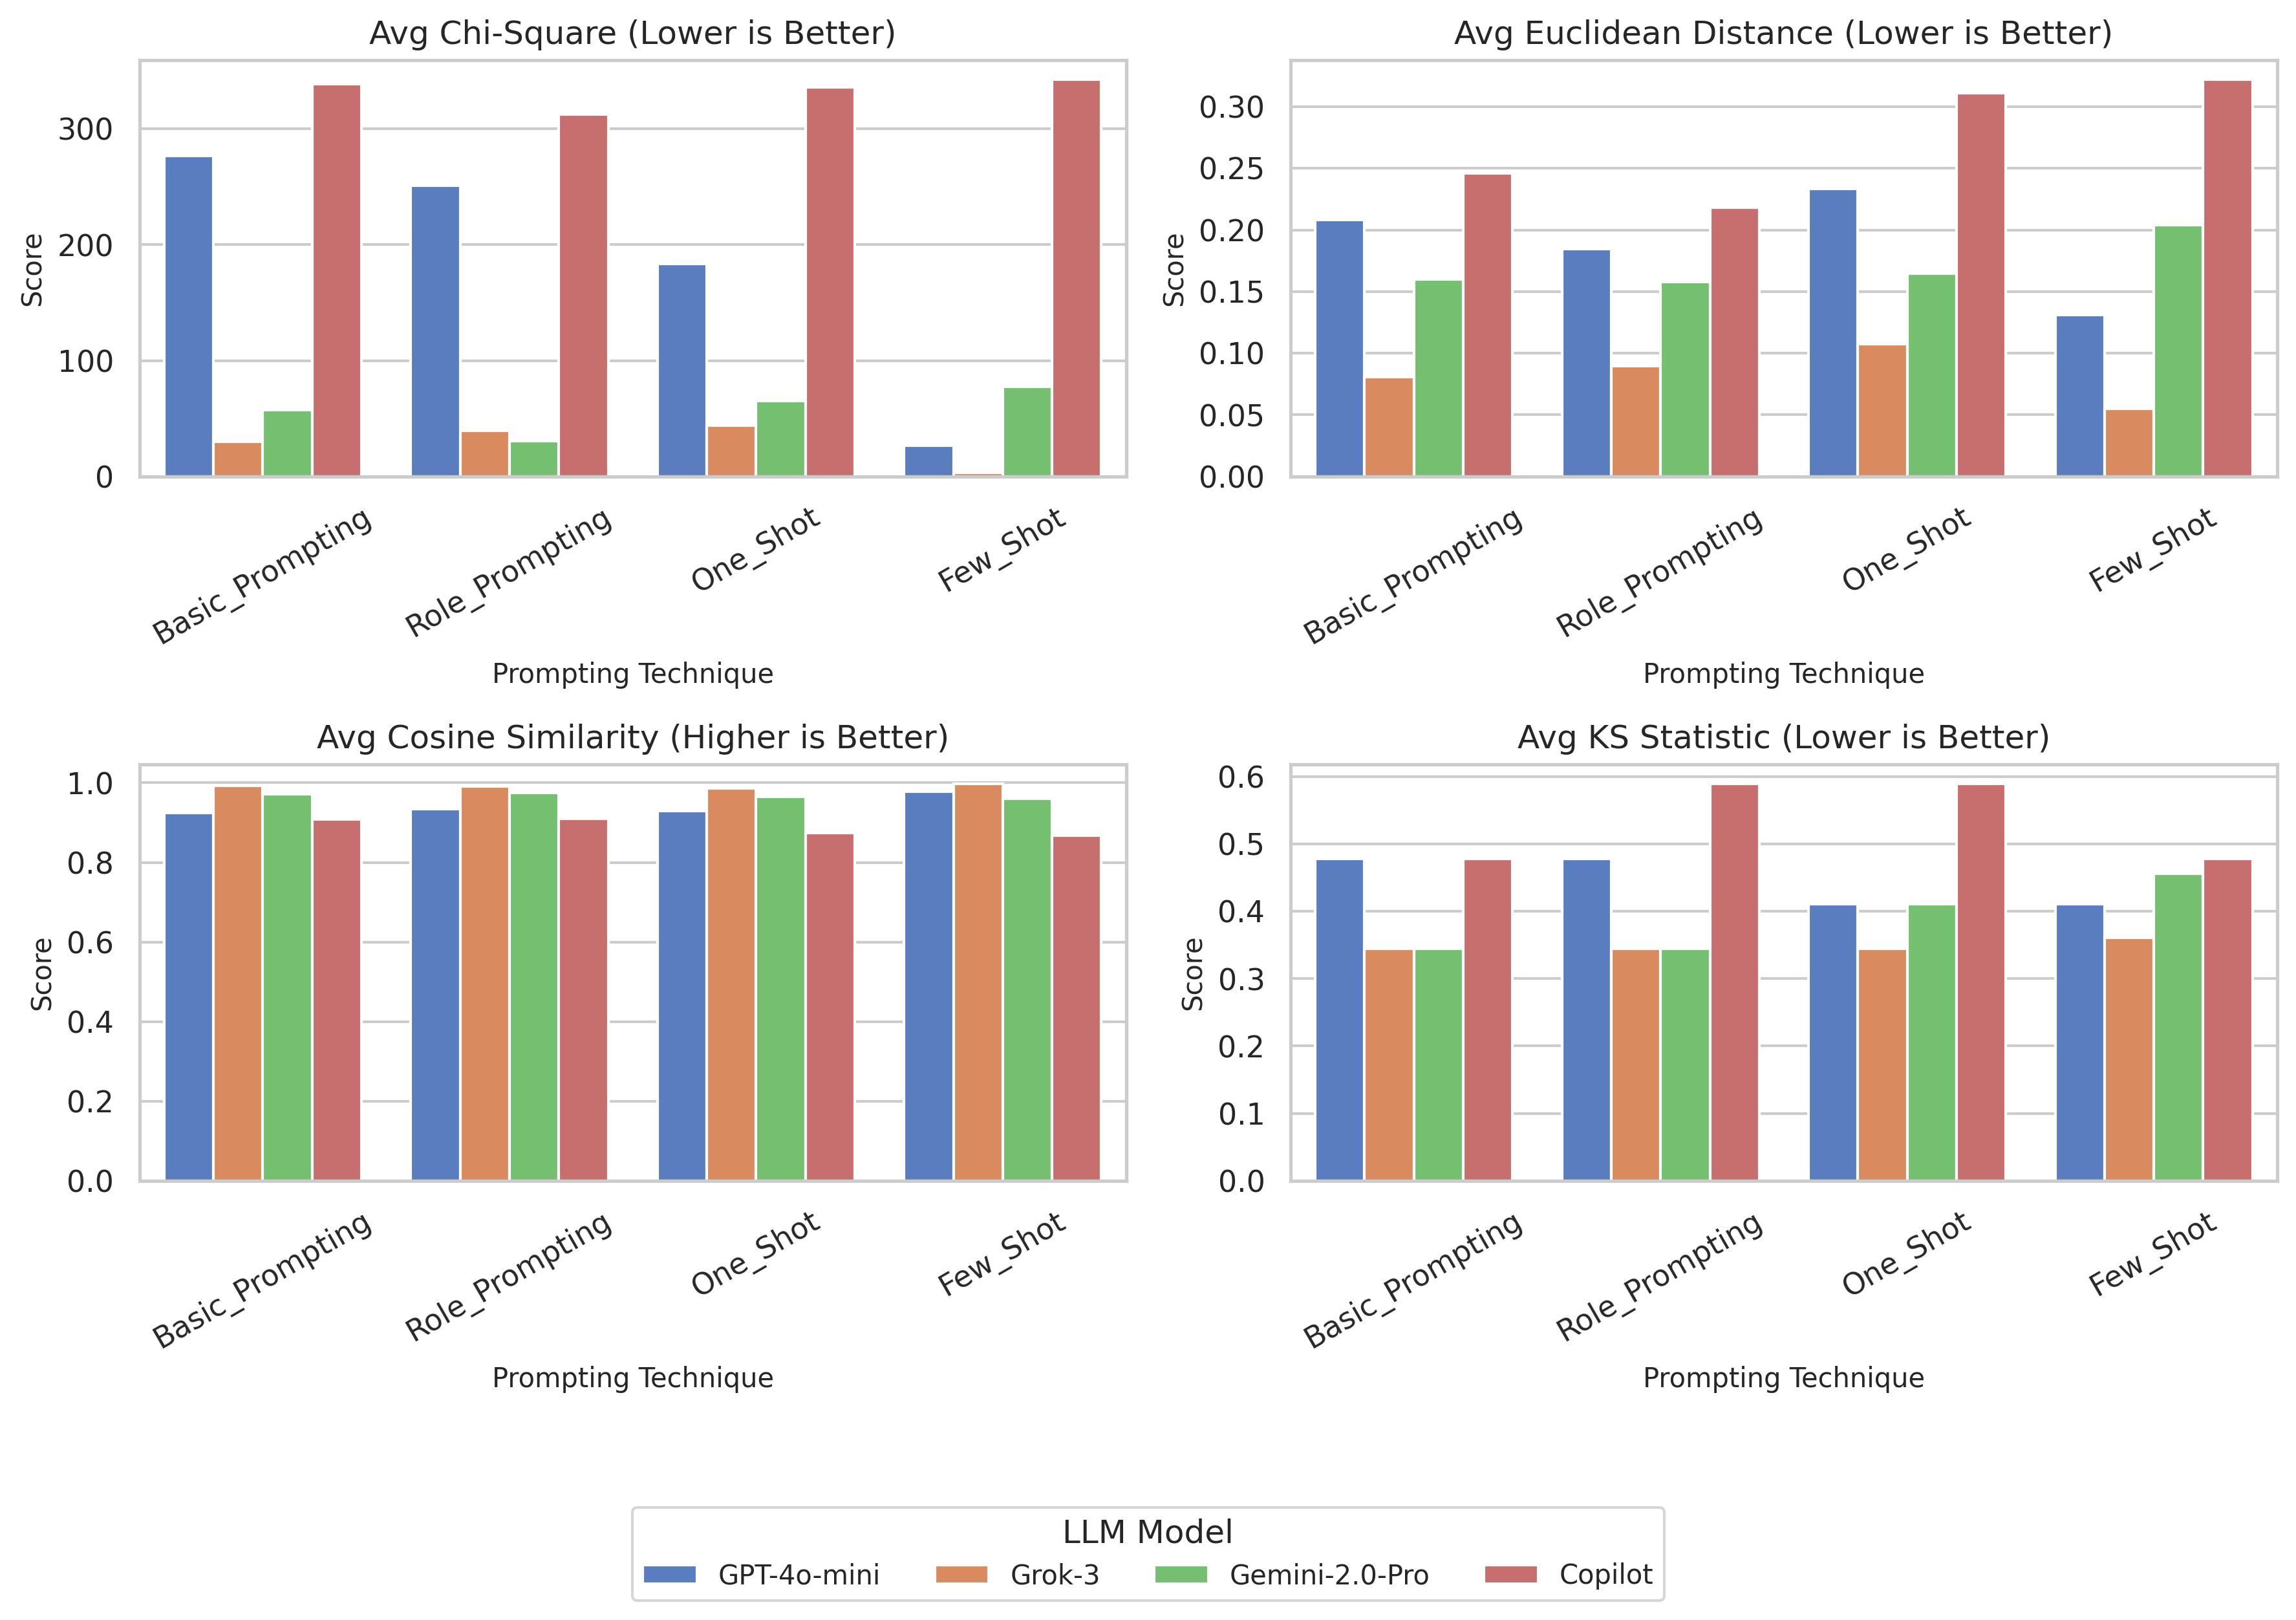

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Ensure that df_table2 exists with the expected columns
if 'df_table2' in locals():
    # Melt the dataframe to long format for easier visualization
    df_melted = df_table2.melt(id_vars=['LLM', 'Technique'],
                               value_vars=['Avg Chi-Square', 'Avg Euclidean', 'Avg Cosine', 'Avg KS'],
                               var_name='Metric', value_name='Score')

    # Define metric descriptions (high/low better)
    metric_titles = {
        "Avg Chi-Square": "Avg Chi-Square (Lower is Better)",
        "Avg Euclidean": "Avg Euclidean Distance (Lower is Better)",
        "Avg Cosine": "Avg Cosine Similarity (Higher is Better)",
        "Avg KS": "Avg KS Statistic (Lower is Better)"
    }

    # Create 2x2 grid for bar plots (compact for reports)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300)
    axes = axes.flatten()

    # Define a color palette for LLM models
    palette = sns.color_palette("muted", n_colors=df_melted['LLM'].nunique())

    # Loop through each metric and create a bar plot
    for i, (metric, title) in enumerate(metric_titles.items()):
        ax = axes[i]
        subset = df_melted[df_melted['Metric'] == metric]
        sns.barplot(data=subset, x="Technique", y="Score", hue="LLM", palette=palette, dodge=True, ax=ax)

        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Prompting Technique", fontsize=10)
        ax.set_ylabel("Score", fontsize=10)
        ax.tick_params(axis='x', rotation=30)

        # Remove individual legends
        ax.legend_.remove()

    # Add a single legend below all plots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="LLM Model", loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=10)

    # Adjust layout to fit everything neatly
    plt.tight_layout(rect=[0, 0.07, 1, 1])  # Leaves space below for the legend
    plt.show()
else:
    print("df_table2 not found. Please ensure the data is generated before plotting.")
